<br><br><font size="6">Análise Longitudinal do Corpus de Cartas Brasileiras (PHPB-Ba)</font>

<p><font size="5" color="darkred">Valter Moreno</font></p>

<font size="3" color="gray">**Fundação Getúlio Vargas (FGV)**<br/>
**Escola de Matemática Aplicada (EMAp)**<br/>
**Mestrado em Matemática Aplicada**<br/>
**Sistemas de Recuperação de Informação - 2019**<br/>
**Prof. Flavio Codeço**<br/></font>

<font size="4" id="tocheading">Índice</font>
<div id="toc"></div>
<br>

In [173]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Objetivos do projeto

Neste projeto, analisamos os manuscritos modernizados do Corpus Eletrônico de Documentos Históricos do Sertão [(CE-DOHS)](http://www.tycho.iel.unicamp.br/cedohs/corpora.html) com os seguintes objetivos:

  - identificar os principais assuntos tratados nos documentos; e
  - avaliar semanticamente o seu conteúdo, ou seja, o significado das palavras de seu vocabulário.
  
Além de obtermos resultados globais para todo o corpus, dividimos os documentos de acordo com as décadas de sua produção, de forma a avaliar mudanças em assuntos e no significado de palavras ao longo do tempo.  

## Corpus analisado

O Corpus Compartilhado Diacrônico – Cartas Brasileiras (PHPB-Ba) é disponibilizado no website do projeto Plataforma Corpus Eletrônico de Documentos Históricos do Sertão [CE-DOHS](http://www5.uefs.br/cedohs/). O projeto é coordenado por Zenaide de Oliveira Novais Carneiro (UEFS/Fapesb/CNPq) e Mariana Fagundes de Oliveira Lacerda (UEFS/Fapesb).

O corpus analisado neste projeto consiste de **1.185 cartas** com datas no período de **1823 a 2000**. As cartas provêm de 14 corporas distintos, listados no [website do CE-DOHS](http://www.tycho.iel.unicamp.br/cedohs/corpora.html).

## Software utilizado

In [139]:
import numpy as np
import os
import glob
import re

import pandas as pd
pd.set_option('precision', 5)
pd.set_option('display.max_colwidth', -1) # Customização do display de dataframes para que
                                          # todo o conteúdo das colunas seja mostrado
import matplotlib.pyplot as plt
%config InteractiveShellApp.pylab_import_all = False
%pylab inline

import seaborn as sns
sns.set(palette='dark', color_codes=True)

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

from collections import defaultdict, Counter
from datetime import datetime
from pprint import pprint
from wordcloud import WordCloud
from string import punctuation
from random import randint, sample

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LsiModel, Word2Vec, word2vec
from gensim.corpora import MmCorpus
from gensim.test.utils import datapath, get_tmpfile

# spaCy
import spacy
nlp = spacy.load("pt_core_news_sm")

# NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#from whoosh.index import create_in, open_dir
#from whoosh.fields import *
#from whoosh.analysis import RegexTokenizer, LanguageAnalyzer, StopFilter, LowercaseFilter, StemFilter
#from whoosh.qparser import QueryParser
#from whoosh.query import Phrase

# Avisos:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vmoreno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Função para a impressão de conteúdo Markdown
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

## Importação dos textos do corpus

O corpus de 1.185 cartas está dividido em arquivos de texto com o conteúdo original e modernizado.  Em nossa análise, utilizamos apenas as cartas com o português modernizado. Um exemplo de manuscrito modernizado é mostrado a seguir.

In [4]:
caminho = "CE-DOHS/*.txt"
arquivos  = glob.glob(caminho)
printmd('**Há um total de <font color="gray">' + str(len(arquivos)) + '</font> arquivos no diretório do corpus.**\n')
printmd('**Nomes dos primeiros arquivos:**')
for i in range(0,8):
    print(arquivos[i])

**Há um total de <font color="gray">2370</font> arquivos no diretório do corpus.**


**Nomes dos primeiros arquivos:**

CE-DOHS/01-AAD-17-04-1962-mod.txt
CE-DOHS/01-AAD-17-04-1962-orig.txt
CE-DOHS/01-ACST-14-01-1952-mod.txt
CE-DOHS/01-ACST-14-01-1952-orig.txt
CE-DOHS/01-AFS-28-04-1956-mod.txt
CE-DOHS/01-AFS-28-04-1956-orig.txt
CE-DOHS/01-APACA-14-01-1980-mod.txt
CE-DOHS/01-APACA-14-01-1980-orig.txt


In [5]:
arquivos = [id for id in arquivos if id.endswith('-mod.txt')]

In [6]:
printmd('**<br/>Conteúdo do primeiro arquivo com português modernizado:**')
with open(arquivos[0]) as f:
    texto = [linha.strip(' \n') for linha in f.readlines() if len(linha.strip(' \n')) > 0] 
pd.DataFrame(texto, columns=['']).style.set_properties(**{'text-align': 'left'})

**<br/>Conteúdo do primeiro arquivo com português modernizado:**

,
0,|:| Corpus Eletrônico de Documento Históricos do Sertão [ CE-DOHS ]
1,|:| Bruna Trindade
2,|:| Carta 01-AAD-17-04-1962
3,|:| Autor: Arnaldo Andrade Dias (apócrifo)
4,|:| Destinatário: Maria de Lourdes de Lima Oliveira
5,|:| Data: 17/04/ 1962
6,|:| Versão modernizada
7,|:| Encoding: UTF-8
8,Carta 1
9,APFFO . 1 de 23 . Documento contendo um fólio . Papel almaço com pautas .


## Extração de metadados e texto dos arquivos

Os arquivos do CE-DOHS incluem metadados em seu cabeçalho identificados pela sequência de caracteres `|:|`. Os seguintes campos são fornecidos:

  * Identificação do corpus
  * Nome da pesqisadora  
  * Identificação da carta
  * Nome do autor da carta
  * Nome do destinatário
  * Data da carta
  * Identificação de carta modernizada
  * Identificação da codificação (UTF-8)
  * Número da carta
  * Descrição do manuscrito (ex., local de arquivo, tipo de papel)
  
Destes, optamos por manter a identificação da carta, o rementente e o destinatário, e a data. Calculamos também o número de palavras em cada documento. Esses metadados foram armazenados num dataframe, confome mostrado posteriormente. 

In [7]:
printmd('**Metadados do primeiro arquivo:**')
pprint([meta for meta in texto if meta.startswith('|:|')])

**Metadados do primeiro arquivo:**

['|:| Corpus Eletrônico de Documento Históricos do Sertão [ CE-DOHS ]',
 '|:| Bruna Trindade',
 '|:| Carta 01-AAD-17-04-1962',
 '|:| Autor: Arnaldo Andrade Dias (apócrifo)',
 '|:| Destinatário: Maria de Lourdes de Lima Oliveira',
 '|:| Data: 17/04/ 1962',
 '|:| Versão modernizada',
 '|:| Encoding: UTF-8']


Para otimizar o uso da memória do computador, criamos uma classe que, quando instanciada, processa os documentos do corpus iterativamente, extraindo os metadados e gravando o texto processado num novo arquivo. O texto de cada carta foi processado da seguinte forma:

  * removemos espaços desnecessários dos nomes dos remetentes e destinatários; 
  * tranformamos as cadeias de caracter das datas originais em datas;
  * removemos o cabeçalho, com os metadados do arquivo; parte deles foi aproveitada para preencher os valores de identificação da carta, autor, destinatário, e data;
  * removemos o texto explicativo geralmente adicionado a cada carta, com informações tais como o tipo de papel usado, o número de folhas, onde a carta estava guardada, etc.
  * removemos notas inseridas no manuscrito para identificar mudanças de página, rasuras, borrados, etc.
  * removemos notas de rodapé, tipicamente explicando que anotações foram feitas no manuscrito
  * separamos trechos demarcados por quebras de linha e pontuações (ponto final, de exclação e de interrogação, ponto e vírgula, e travessão) em linhas. 

In [158]:
class CartasCorpus:
    def __init__(self, arquivos, pasta, ndocs=100, inicio=10):
        self.arquivos = arquivos
        self.pasta = pasta
        self.ndocs = min(len(arquivos),ndocs)
        self.inicio = inicio
    '''
    Para cada os ndocs primeiros arquivos do corpus, os metadados são extraídos e adicionados
    ao dataframe passado na criação do objeto. Além disso, o conteúdo do arquivo é processado 
    de acordo com o tipo de processamento especificado, e gravado num arquivo com o mesmo ID do
    arquivo original e o sufixo "-proc.txt".
    '''    
    def __iter__(self):
        for fileid in self.arquivos[:self.ndocs]:
            meta_dic = dict()            
            
            ''' Lê o conteúdo do arquivo numa lista de linhas:
            '''
            with open(fileid, mode="r", encoding="utf-8") as doc:
                texto = doc.read()
                
            linhas = [linha for linha in texto.split('\n') if len(linha) > 0]
            
            ''' Cria um dicionário a partir das linhas de metadados:
            '''
            meta_dic['ID'] = fileid.replace('CE-DOHS/','').replace('-mod.txt','')
            
            meta_dic['Palavras'] = len(texto.split())
                        
            rem = [autor.replace(u'|:| Autor:', '').strip(' .\n') \
                   for autor in linhas \
                   if u'|:| Autor:' in autor][0]
            meta_dic['Remetente'] = rem if len(rem) > 0 else np.NaN
            
            dest = [dest.replace(u'|:| Destinatário:', '').strip(' .\n') \
                    for dest in linhas \
                    if u'|:| Destinatário:' in dest][0]
            meta_dic['Destinatário'] = dest if len(dest) > 0 else np.NaN
            
            ''' Tenta obter a data da carta:
            '''
            data = [data.replace(u'|:| Data:', '').strip(' .\n').lower() \
                    for data in linhas \
                    if u'|:| Data:' in data][0]
            meses = ['janeiro','fevereiro','mar','abril','maio','junho',
                     'julho','agosto','setembro','outubro','novembro','dezembro'] 
            mes = [mes for mes in meses if mes in data]
            if mes:
                data = data.replace(mes[0], '/' + str(meses.index(mes[0]) + 1) + '/')
            data_num = re.compile('[0-9\/]')
            data = data_num.findall(data)
            data = ''.join(data)
            try:
                data_dt = pd.to_datetime(data, infer_datetime_format=True)
                if pd.isna(data_dt) or data_dt.year > 2000 or data_dt.year < 1823:
                    data = self.data_id(fileid)
                else:
                    data = data_dt.strftime("%d/%m/%Y")
            except:
                data = self.data_id(fileid)
            meta_dic['Data'] = data
                
            ''' Processa as linhas e retorna uma nova lista com elementos do
                tipo especificado:
            '''
            texto = self.proc_texto(linhas, self.inicio)

            filtradas = 0
            for linha in texto:
                filtradas += len(linha.split())
            meta_dic['Filtradas'] = filtradas
            
            ''' Grava o arquivo com o texto processado no diretório 'CE-DOHS-proc/':
            '''
            if not os.path.exists(self.pasta):
                os.makedirs(self.pasta)
                
            nome = self.pasta + meta_dic['ID'] + '-proc.txt'
            with open(nome,'w+') as arquivo:
                arquivo.writelines("%s\n" % linha for linha in texto)                    
            
            yield meta_dic
                    
    def data_id(self, fileid):
        '''
        No corpus Corpus Eletrônico de Documentos Históricos do Sertão, a maior parte dos
        nomes dos arquivos inclui a data da carta. Esta função tenta recuperar essa data 
        a partir do nome do arquivo. O resultado gerado é um objeto to tipo datetime ou NaN.
        '''
        data_num = re.compile('[0-9]{2}-[0-9]{2}-[0-9]{4}')
        data = data_num.findall(fileid)
        if data:
            try:
                data_dt = pd.to_datetime(data[0], format='%d-%m-%Y')
                if pd.isna(data_dt):
                    return np.NaN
                else:
                    return data_dt.strftime("%d/%m/%Y") 
            except:
                return np.NaN
        else:
            return np.NaN

    def proc_texto(self, linhas, inicio):
        '''
        Processa cada linha do conteúdo do documento, a partir da linha de inicial passada (inicio),
        de acordo com o tipo de processamento especificado. Retorna uma lista com os resultados.
        '''
        ''' Converte as linhas do texto num único string:
        '''
        texto = linhas[inicio:len(linhas)]
        texto = '\n'.join(texto)
        
        ''' Elimina caracteres e comentários indesejáveis:
        '''
        texto = texto.replace('[pag]', '')
        texto = re.sub('\[footer:([\\n a-zA-Z0-9áàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ.,!?;:<>()-_#\'\"‘’“”]*)\]',
                                 '', texto)
        texto = re.sub('\[header:[ ]*\]', '\n', texto)
        texto = re.sub('[|]*[ ]*[Ff]l. [0-9] [rv]', ' ', texto)
        texto = re.sub('[0-9][ ]*Rasura[do]*[ .]*', ' ', texto)
        texto = re.sub('[0-9][ ]*Borrado[ .]*', ' ', texto)
        texto = re.sub('\[[ ]*[Rr]ubrica[ ]*\]', ' ', texto)
        texto = re.sub('\[[ ]*[Rr]asura[ ]*\]', ' ', texto)
        texto = re.sub('\[[ ]*[Ii]nint[ ]*.[ ]*\]', ' ', texto)
        texto = re.sub('Sr. ', 'Sr ', texto)
        texto = re.sub('Sra. ', 'Sra ', texto)
        texto = re.sub('Dr. ', 'Dr ', texto)
        texto = re.sub('Dra. ', 'Dra ', texto)
        texto = re.sub('V. ', 'V ', texto)
        texto = re.sub('Exa. ', 'Exa ', texto)
        texto = re.sub(' = ', '', texto)
        texto = re.sub(u'[↑¹²³⁴⁵⁶⁷⁸⁹|<>\(\)\[\]‘’“”\'\"]+', '', texto)
        texto = re.sub(r' +', ' ', texto)
        texto = texto.strip()
        
        linhas = [linha for linha in texto.split('\n') if len(linha) > 0]
        linhas = self.quebra_linhas(linhas, ['?', '!', '.', ';', '–'])
        
        return linhas
    
    def quebra_linhas(self, linhas, pontos):
        for ponto in pontos:
            novas = []
            for linha in linhas:
                if ponto in linha:
                    linha=linha.replace(ponto, ' ' + ponto + '\n')
                    novas.extend([l.strip() 
                                  for l in linha.split('\n') 
                                  if len(l.strip(punctuation).strip()) > 0])
                else:
                    if len(linha.strip(punctuation).strip()) > 0:
                        novas.extend([linha.strip()])
            linhas = [linha for linha in novas]

        return novas

Instanciamos a classe criando um objeto que se comporta como um iterador. O processamento dos textos do corpus só é efetivamente realizado ao longo das iterações do *loop* `for doc in dic:` no trecho de código a seguir.

In [159]:
metadados = pd.DataFrame(columns=['ID', 'Palavras', 'Filtradas', 'Remetente', 'Destinatário', 'Data'])

dic = CartasCorpus(arquivos, 'CE-DOHS-proc/', ndocs=10000)

for doc in dic:
    metadados = metadados.append(doc, ignore_index=True)

Abaixo, motramos o dataframe com os resultados da extração dos metadados dos textos do corpus.

In [160]:
metadados

,ID,Palavras,Filtradas,Remetente,Destinatário,Data
0,01-AAD-17-04-1962,243,169,Arnaldo Andrade Dias (apócrifo),Maria de Lourdes de Lima Oliveira,17/04/1962
1,01-ACST-14-01-1952,349,267,Antonio Carneiro da Silva Tuy,Maria de Souza Estrela,14/01/1952
2,01-AFS-28-04-1956,256,181,Antonio Fortunato da Silva,João Carneiro de Oliveira,28/04/1956
3,01-APACA-14-01-1980,469,393,Adelmário Carneiro de Araújo,Eliana de Oliveira Lima,14/01/1980
4,01-ASA-14-05-1955,221,139,Acioly Silva Araújo,Dantas Junior,14/05/1955
...,...,...,...,...,...,...
1180,98-VOV-28-11-1934,404,325,Virginia Ottoni Vieira,Yáyá,28/11/1934
1181,99-AJN-26-05-1878,279,196,Antonio Jose Nogueira,Doutor Martim Francisco Ribeiro de Andrade,26/05/1878
1182,99-DCO,219,112,Doralice Carneiro de Oliveira Jesus,Zenilta Bispo de Oliveira,NaN
1183,99-HRS-01-01-1931,483,397,Hermínio Reis [Silva],Dantas Junior,01/01/1931


O conteúdo processado de um arquivo escolhido aleatoriamente é exibido a seguir.

In [11]:
id = metadados.ID[randint(0, 1184)]

fileid = 'CE-DOHS-proc/' +  id + '-proc.txt'

with open(fileid, mode="r", encoding="utf-8") as doc:
    linhas = [linha.strip('\n') for linha in doc.readlines()]

printmd('**Carta ' + id + ':**')

for linha in linhas:
    pprint(linha)

**Carta 11-JPL-09-07-1849:**

'Ilustríssima e Excelentíssima Senhora Dona Maria Clementina da Costa  .'
'Santo Amaro 9 de Julho 1849'
'Pouco mais ou menos 11'
'Muito minha Senhora'
('Diversas Cartas tenho eu enviado a Vossa Excelência , escritas pela Madre '
 'Abbadeça do Convento do Desterro , por que tanto me tem pedido : entre essas '
 'diversas , foi a inclusa 12 a muito tempo que pedi a Jacinto JozeRuas de São '
 'Felix para remeter a Vossa Excelência : a qual a pouco ma mandou dizendo-me '
 'que ninguém dava notícia desta Senhora : Creio que a causa foi dizer se no '
 'sobrescrito  ;')
'- no seu Engenho Cachoeira  –'
('e não falar no Iguape : queira pois Vossa Excelência receber , e dar uma '
 'resposta a seu conteúdo , ainda mesmo que á pouco tenha escrito a Madre '
 'Abbadeça : pois desejo que ela não pense que Vossa Excelência recebeu esta , '
 'e não deu resposta  .')
('Como tenho esta ocasião direi a Vossa Excelência , que a mesma Madre '
 'Abbadeça , me tem querido encarregar desta cobrança por favor  ;

## Análise exploratória dos metadados

Os documentos do corpus são cartas, geralmente de tamanho reduzido, como mostram o histograma e as estatísticas descrivas abaixo. Setenta e cinco por cento das cartas têm até 455 palavras, incluindo o cabeçalho com os metadados (nome do corpus, pessoa responsável, identificação da carta, autor, destinatário, data, versão, e codificação).

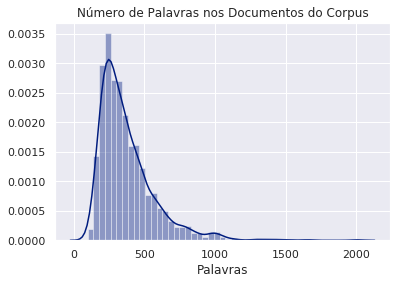

In [132]:
ax = sns.distplot(metadados.Palavras)
ax.set_title('Número de Palavras nos Documentos do Corpus')
plt.show()

In [13]:
printmd('**Estatísticas descritivas do número de palavras:**')
print(round(pd.to_numeric(metadados.Palavras).describe(),1))

**Estatísticas descritivas:**

count    1185.0
mean     375.8 
std      201.0 
min      99.0  
25%      239.0 
50%      323.0 
75%      455.0 
max      2007.0
Name: Palavras, dtype: float64


Uma vez que o pré-processamento dos textos incluiu a eliminação de metadados e comentários incluídos nos documentos originais, o número de palavras nos documentos processados é menor do que nos originais.

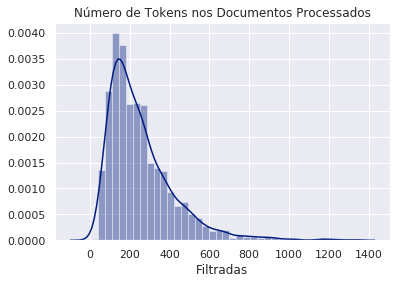

In [161]:
ax = sns.distplot(metadados.Filtradas)
ax.set_title('Número de Tokens nos Documentos Processados')
plt.show()

In [162]:
printmd('**Estatísticas descritivas para os documentos processados:**')
print(round(pd.to_numeric(metadados.Filtradas).describe(),1))

**Estatísticas descritivas para os documentos processados:**

count    1185.0
mean     253.9 
std      167.3 
min      7.0   
25%      137.0 
50%      210.0 
75%      324.0 
max      1324.0
Name: Filtradas, dtype: float64


### Número de cartas por ano

Uma vez que desejávamos avaliar as diferenças entre tópicos e significados de palavras ao longo tempo, era importante avaliar como os textos analisados estavam distribuídos ao longo do período compreendido no corpus (1823-2000). O gráfico a seguir mostra a evolução do número de cartas disponíveis em cada ano desse período. 

In [14]:
anos = [data[-4:] if not pd.isnull(data) else np.nan for data in metadados.Data.tolist()]
anos = [int(ano) if not pd.isnull(ano) else np.nan for ano in anos]
freq = pd.DataFrame(Counter(anos).items(), columns=['Ano','Frequência']).sort_values(by='Ano')

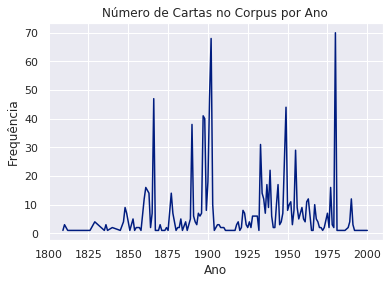

In [15]:
ax = sns.lineplot(x='Ano', y='Frequência', data=freq)
ax.set_title('Número de Cartas no Corpus por Ano')
plt.show()

O gráfico acima mostra diferenças substanciais no número de documentos por ano. Além disso, na maior parte dos anos, a frequência é inferior a 30 documentos. Antevendo a necessidade de treinamento dos modelos usados nas análises posteriores, decidimos avaliar possibilidades de agregação por intervalo de tempo (ex., 10 em 10 anos, 20 em 20, etc.). Os resultados para algumas alternativas são apresentados nos próximos gráficos.

In [16]:
def bar_periodo(dados, inicio=1823, periodo=10, fim=2000):
    freq_dic = dict()
    freq_dic[inicio] = freq.loc[[ano <= inicio \
                                 if not pd.isnull(ano) else False \
                                 for ano in freq.Ano]]['Frequência'].sum()
    for decada in range(inicio, fim, periodo):
        limite = decada + periodo if decada + periodo < fim else 2000
        freq_dic[limite] = freq.loc[[(ano > decada and ano <= limite) \
                                               if not pd.isnull(ano) else False \
                                               for ano in freq.Ano]]['Frequência'].sum()
    freq_periodo = pd.DataFrame(columns=['Ano', 'Frequência'])
    freq_periodo.Ano = freq_dic.keys()
    freq_periodo.Frequência = freq_dic.values()
    ax = sns.barplot(x='Ano', y='Frequência', data=freq_periodo)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title('Número de Cartas por Período')
    plt.show()

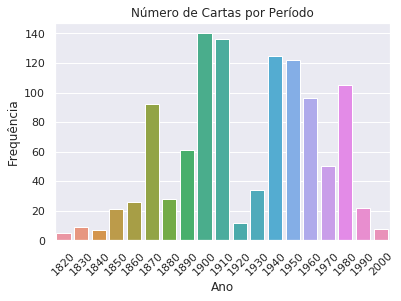

In [17]:
bar_periodo(freq, 1820, 10, 2000)

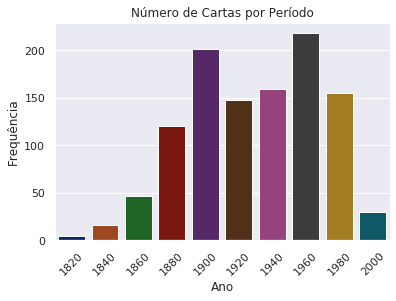

In [18]:
bar_periodo(freq, 1820, 20, 2000)

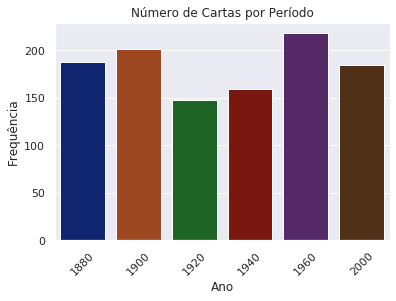

In [19]:
bar_periodo(freq, 1880, 20, 1980)

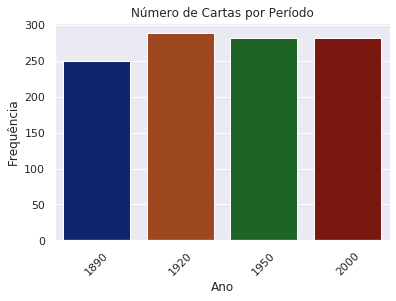

In [20]:
bar_periodo(freq, 1890, 30, 1980)

A opção de agrupamento acima é bem equilibrada em termos de número de documentos por período (entre 250 e 300 cartas). Além disso, inclui um número de faixas suficiente para representar períodos importantes da história brasileira:

  - **1823-1890**: Império
  - **1890-1920**: início da República
  - **1920-1950**: era Vargas, Segunda Grande Guerra, Juscelino Kubitschek
  - **1950-2000**: ditadura e democratização
  
Esses períodos foram adotados na análise longitudinal de tópicos e significados, descrita posteriormente.

### Remetentes e destinatários

Os metadados coletados incluem informações do remetente e do destinatário de uma carta. Verificamos que o número de remetentes únicos é bastante superior ao de destinatários. Além disso, ambos representam percentuais relativamente baixos do total de cartas do corpus. Logo, há mais de uma carta de um mesmo remetente, e várias cartas para um mesmo destinatário.

In [21]:
remetentes = len(metadados.Remetente.unique())
destinatarios = len(metadados.Destinatário.unique())
n_cartas = metadados.shape[0]

printmd('**Número de remetentes únicos no corpus: <font color="gray">' + 
        str(remetentes) + ' (' + str(round(100*remetentes/n_cartas, 2)) + '%)</font>**')
printmd('**Número de destinatários únicos no corpus: <font color="gray">' + 
        str(destinatarios) + ' (' + 
        str(round(100*destinatarios/n_cartas, 2)) + '%)</font>**')

**Número de remetentes únicos no corpus: <font color="gray">555 (46.84%)</font>**

**Número de destinatários únicos no corpus: <font color="gray">234 (19.75%)</font>**

O histograma do número de cartas de cada remetente indica que a vasta maioria dos remetentes escreveu menos de 10 cartas. Em torno de 3.2% dos remententes no corpus foram autores de mais de 10 documentos.

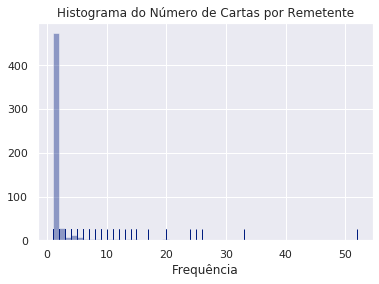

In [22]:
freq_rem = pd.DataFrame(Counter(metadados.Remetente).items(), 
                        columns=['Remetente', 'Frequência'])\
             .sort_values(by=['Frequência'], ascending=False)

ax = sns.distplot(freq_rem.Frequência, kde=False, rug=True)
ax.set_title('Histograma do Número de Cartas por Remetente')
plt.show()

In [23]:
n_rem = len(freq_rem.loc[freq_rem.Frequência > 10])

printmd('**Número de remetentes com mais de 10 cartas no corpus: <font color="gray">' + 
        str(n_rem) + ' (' + str(round(100*n_rem/remetentes, 2)) + '%)</font>**')

**Número de remetentes com mais de 10 cartas no corpus: <font color="gray">18 (3.24%)</font>**

In [24]:
printmd('<br/>**Remetentes de mais de 10 cartas:**')
freq_rem.loc[freq_rem.Frequência > 10]

<br/>**Remetentes de mais de 10 cartas:**

,Remetente,Frequência
266,Aracy Leonardo Pereira,52
8,João Pinto Leite,33
2,Antonio Fortunato da Silva,26
5,Antonia Thereza Wanderley,25
144,Benicio Penalva de Faria (B. Penalva),24
262,Francisco Mendes da Rocha,20
0,Arnaldo Andrade Dias (apócrifo),20
41,F. Octaviano [Francisco Octaviano de Almeida Rosa],17
11,Renée da Silva Barros Soledade,15
17,Otto Soledade Júnior,15


Da mesma forma, vemos que poucas pessoas foram destinatárias de mais de 10 cartas. 

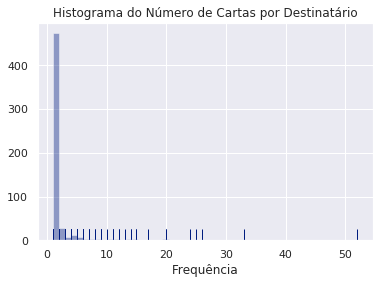

In [25]:
freq_dest = pd.DataFrame(Counter(metadados.Remetente).items(), 
                        columns=['Destinatário', 'Frequência'])\
             .sort_values(by=['Frequência'], ascending=False)

ax = sns.distplot(freq_dest.Frequência, kde=False, rug=True)
ax.set_title('Histograma do Número de Cartas por Destinatário')
plt.show()

In [26]:
n_dest = len(freq_dest.loc[freq_dest.Frequência > 10])

printmd('**Número de destinatários com mais de 10 cartas no corpus: <font color="gray">' + 
        str(n_dest) + ' (' + 
        str(round(100*n_dest/destinatarios, 2)) + '%)</font>**')

**Número de destinatários com mais de 10 cartas no corpus: <font color="gray">18 (7.69%)</font>**

In [27]:
printmd('<br/>**Destinatários de mais de 10 cartas:**')
freq_dest.loc[freq_dest.Frequência > 10]

<br/>**Destinatários de mais de 10 cartas:**

,Destinatário,Frequência
266,Aracy Leonardo Pereira,52
8,João Pinto Leite,33
2,Antonio Fortunato da Silva,26
5,Antonia Thereza Wanderley,25
144,Benicio Penalva de Faria (B. Penalva),24
262,Francisco Mendes da Rocha,20
0,Arnaldo Andrade Dias (apócrifo),20
41,F. Octaviano [Francisco Octaviano de Almeida Rosa],17
11,Renée da Silva Barros Soledade,15
17,Otto Soledade Júnior,15


## Modelagem de tópicos

Para a modelagem de tópicos do corpus, utilizamos o algoritmo de Indexação Semântica Latente [(Latent Semantic Indexing - LSI)](https://en.wikipedia.org/wiki/Latent_semantic_analysis) da biblioteca [gensim](https://radimrehurek.com/gensim/). 

Inicialmente, mantivemos os textos das cartas originais sem alterações. Após os tokenizarmos, retendo a capitalização original e os *stop words*, criamos um modelo LSI com os 100 maiores autovalores na transformação SVD (*num_topics*) implementada no algoritmo. De acordo com [Bradford (2008)](https://doi.org/10.1145/1458082.1458105), para um corpus com milhões de documentos, valores entre 300 e 500 tendem a gerar resultados satisfatórios, enquanto valores entre 70 e 100 podem ser mais adequados para corpora menores ([Dumais, 1991](https://link.springer.com/content/pdf/10.3758/BF03203370.pdf).

Em seguida, repetimos a análise usando textos tokenizados, sem *stop words*, sem nomes próprios, em minúsculas, e lematizados. Para isso, usamos os seguintes procedimentos: 
  - A tokenização foi feita com a biblioteca [spaCy](https://spacy.io/usage/linguistic-features#tokenization). 
  - A deleção de *stop words* foi feita com base numa lista obtida da união das palavras disponíveis nas biblotecas [spaCy](https://spacy.io/usage/spacy-101) e [nltk](http://www.nltk.org/), complementada com pronomes pessoais, possessivos e de tratamento (ex., Excelentíssimo, Vossa Excelência, etc.), artigos indefinidos, alguns advérbios, e com as palavras da lista capitalizadas. Tokens com apenas um caracter foram descartados.
  - Há poucas alternaticas para implementar a lematização na língua portuguesa, todas com performance ainda abaixo das opções para a língua inglesa (https://lars76.github.io/nlp/lemmatize-portuguese/). Optamos por realizar a lematização com a biblioteca spaCy (https://spacy.io/api/lemmatizer).
  - A remoção de nomes próprios foi feita com auxílio da funcionalidade [*part-of-speach tagging*](https://spacy.io/usage/linguistic-features) da biblioteca spaCy. 

Como feito antes, para otimizar o uso da memória, criamos uma classe que implementa um iterador. Quando objeto da classe é iterado, o arquivo referente a uma carta do corpus é lido, e seu conteúdo é tokenizado e alimentado ao corpus e ao dicionário do gensim. O corpus utiliza o modelo [bag of words](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html). 

A implementação da classe permite que, na criação do iterador, se defina se os *stop words* e nomes próprios serão removidos, se haverá lematização, e se os tokens serão passados para minúsculas. Tokens com apenas um caracter são removidos.

**Criação do conjunto de *stop words*:**

In [353]:
spacy_stopwords = spacy.lang.pt.stop_words.STOP_WORDS
printmd('**Número de *stop words* em português no spaCy: <font color="gray">' + str(len(spacy_stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(sorted(list(spacy_stopwords))[:20])

**Número de *stop words* em português no spaCy: <font color="gray">413</font>**

**Primeiros *stop words* na lista:**

['acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após']


In [354]:
nltk_stopwords = sorted(nltk.corpus.stopwords.words('portuguese'))
printmd('**Número de *stop words* em português no nlkt: <font color="gray">' + str(len(nltk_stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(nltk_stopwords[:20])

**Número de *stop words* em português no nlkt: <font color="gray">204</font>**

**Primeiros *stop words* na lista:**

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois']


In [356]:
adicionais = {'você', 'vosmecê', 'porém', 'todavia', 'contudo', 'entretanto', 'entanto', 'logo', 'pois',
              'assim', 'conseguinte', 'nem', 'também', 'obstante', 'talvez', 'logo', 'pois', 'portanto',
              'isso', 'aquilo', 'aquiloutro', 'porquanto', 'senão', 'pelo', 'pelos', 'pela', 'pelas', 'dr', 'dra', 'sr', 'sra', 'srta', 
              'doutor', 'doutora', 'senhor', 'senhora', 'senhorita', 'v', 'sa', 'vossa', 'senhoria', 
              'exa', 'excelência', 'ema', 'eminência', 's', 'santidade', 'rev', 'reverendíssima', 
              'alteza', 'm', 'majestade', 'magnificência', 'excelentíssimo', 'excelentíssima', 
              'excelentíssimos', 'excelentíssimas', 'ilustríssimo', 'ilustríssimos', 'ilustríssima',
              'ilustríssimas', 'compadre', 'comadre', 'prezado', 'prezada', 'compadres', 
              'comadres', 'prezados', 'prezadas', 'mim', 'comigo', 'ti', 'contigo', 'ele', 'ela', 'si',
              'consigo', 'nós', 'conosco', 'vós', 'convosco', 'eles', 'elas', 'si', 'consigo', 
              'me', 'te', 'o', 'a', 'se', 'lhe', 'lha', 'lho', 'nos', 'vos', 'os', 'as', 'se', 'lhes', 
              'lhos', 'lhas', 'lo', 'los', 'la', 'los', 'no', 'nos', 'na' , 'nas', 'meu', 'minha', 
              'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'seu', 'sua', 'seus', 'suas', 
              'nosso', 'nossa', 'nossos', 'nossos', 'vosso', 'vossa', 'vossos', 'vossas', 'um', 'uns', 'uma',
              'umas', 'muito', 'muita', 'muitos', 'muitas', 'pouco', 'poucos', 'pouca', 'poucas', 'mesmo',
              'mesmos', 'mesmo', 'mesmas'}

adicionais = adicionais.union([x.capitalize() for x in list(adicionais)])

stopwords = set(spacy_stopwords).union(nltk_stopwords)

stopwords = stopwords\
              .union([word.capitalize() for word in list(stopwords)])\
              .union(adicionais)

stopwords = list(stopwords)

printmd('**Número de *stop words* nas duas bibliotecas: <font color="gray">' + str(len(stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(sorted(stopwords)[:50])

with open('stopwords.txt', 'w+') as file:
    file.writelines("%s\n" % word for word in sorted(stopwords))

<class 'list'>


**Número de *stop words* nas duas bibliotecas: <font color="gray">1138</font>**

**Primeiros *stop words* na lista:**

['A', 'Acerca', 'Ademais', 'Adeus', 'Agora', 'Ainda', 'Algo', 'Algumas', 'Alguns', 'Ali', 'Alteza', 'Além', 'Ambas', 'Ambos', 'Antes', 'Ao', 'Aos', 'Apenas', 'Apoia', 'Apoio', 'Apontar', 'Após', 'Aquela', 'Aquelas', 'Aquele', 'Aqueles', 'Aqui', 'Aquilo', 'Aquiloutro', 'As', 'Assim', 'Através', 'Atrás', 'Até', 'Aí', 'Baixo', 'Bastante', 'Bem', 'Boa', 'Bom', 'Breve', 'Cada', 'Caminho', 'Catorze', 'Cedo', 'Cento', 'Certamente', 'Certeza', 'Cima', 'Cinco']


**Definição da classe para a criação de corpus no gemsin:**

In [31]:
class GensimCorpus:
    def __init__(self, pasta, IDs, sufixo, dicionario, stop_words, 
                 lower=True, lema=False, nomes=False, num=False):
        self.pasta = pasta
        self.IDs = IDs
        self.sufixo = sufixo
        self.dicionario = dicionario
        self.stop = stop_words
        self.lower = lower
        self.lema = lema
        self.nomes = nomes
        self.num = num

    def __iter__(self):
        for id in self.IDs:
            fileid = self.pasta + id + self.sufixo
            
            with open(fileid, mode="r", encoding="utf-8") as doc:
                texto = doc.read()
                
            texto = nlp(texto)

            if self.nomes and not self.lema:
                tokens = [token.orth_ for token in texto if token.pos_ != 'PROPN']
            elif self.lema and not self.nomes:
                tokens = [token.lemma_ for token in texto]
            elif self.nomes and self.lema:
                tokens = [token.lemma_ for token in texto if token.pos_ != 'PROPN']
            else:
                tokens = [token.orth_ for token in texto]

            if self.lower:
                tokens = [token.lower() for token in tokens]
            
            tokens = [token for token in tokens 
                      if token not in self.stop and len(token) > 1]
            
            if self.num:
                tokens = [re.sub('[$:0-9]*', '', token) 
                          for token in tokens]
                tokens = [token for token in tokens if len(token) > 1]
                
            self.dicionario.add_documents([tokens])

            yield self.dicionario.doc2bow(tokens)

In [39]:
if not os.path.exists('Modelos/'):   # se necessário, cria pasta para corpora dos modelos
    os.makedirs('Modelos/')

### Resultados com mínimo pré-processamento dos textos

Na primeira análise, criamos o corpus do gensim com os textos tokenizados, sem a exclusão de *stop words* e nomes próprios, lematização, ou passagem dos tokens para minúsculas.

In [38]:
dic_gensim = corpora.Dictionary()

corpus_gensim = GensimCorpus('CE-DOHS-proc/', metadados.ID , '-proc.txt', dic_gensim, [],
                             lower=False, lema=False, nomes=False, num=False)

Como sugerido no [tutorial do gensim](https://radimrehurek.com/gensim//auto_examples/core/run_topics_and_transformations.html), a transformação LSI recebeu como entrada o resultado da transformação do corpus para o espaço tf-idf.

In [50]:
if os.path.exists('Modelos/modelo_tfidf_min.md') and \
   os.path.exists('Modelos/corpus_tfidf_min.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_min.md')    # carrega o modelo tf-idf
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_min.cp')           # carrega o corpus tf-idf
else:
    modelo_tfidf = TfidfModel(corpus_gensim, normalize=True)         # inicialização da trasnformação tf-idf
    corpus_tfidf = modelo_tfidf[corpus_gensim]                       # transformação do corpus
    modelo_tfidf.save('Modelos/modelo_tfidf_min.md')                 # salva o modelo tf-idf
    MmCorpus.serialize('Modelos/corpus_tfidf_min.cp', corpus_tfidf)  # salva o corpus tf-idf

O modelo LSI foi criado com o corpus transformado para o espaço tf-idf.

In [51]:
if os.path.exists('Modelos/modelo_lsi_min_100.md') and \
   os.path.exists('Modelos/corpus_lsi_min_100.cp'):
    modelo_lsi = LsiModel.load('Modelos/modelo_lsi_min_100.md')
    corpus_lsi = MmCorpus('Modelos/corpus_lsi_min_100.cp')
else:
    modelo_lsi = LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi = modelo_lsi[corpus_tfidf]    
    modelo_lsi.save('Modelos/modelo_lsi_min_100.md')
    MmCorpus.serialize('Modelos/corpus_lsi_min_100.cp', corpus_lsi)

O primeiro tópico, com os pesos dos primeiros 100 tokens, é mostrado abaixo. 

In [44]:
printmd('**100 primeiras palavras do primeiro tópico identificado:**')
pprint(modelo_lsi.print_topics(num_topics=1, num_words=100)[0][1])

**100 primeiras palavras do primeiro tópico identificado:**

('0.160*"Vossa" + 0.156*"Excelência" + 0.150*"você" + 0.136*"eu" + 0.091*"ele" '
 '+ 0.089*"compadre" + 0.088*"me" + 0.085*"não" + 0.080*"minha" + 0.079*"lhe" '
 '+ 0.078*"meu" + 0.077*"os" + 0.077*"por" + 0.074*"dia" + 0.074*"amigo" + '
 '0.073*"um" + 0.073*"mas" + 0.073*"aqui" + 0.073*"as" + 0.072*"no" + '
 '0.072*"em" + 0.071*"te" + 0.071*"muito" + 0.071*"Deus" + 0.071*"mais" + '
 '0.071*"se" + 0.070*"bem" + 0.070*"sua" + 0.070*"uma" + 0.070*"pois" + '
 '0.069*"está" + 0.069*"como" + 0.068*"seu" + 0.068*"tem" + 0.068*"já" + '
 '0.067*"foi" + 0.066*"senhor" + 0.066*"Dr" + 0.066*"todos" + 0.065*"mim" + '
 '0.065*"esta" + 0.065*"na" + 0.065*"tenho" + 0.064*"vou" + 0.063*"vai" + '
 '0.063*"João" + 0.062*"carta" + 0.061*"este" + 0.061*"Senhor" + 0.061*"estou" '
 '+ 0.060*"ela" + 0.060*"só" + 0.060*"dos" + 0.059*"mesmo" + 0.059*"ou" + '
 '0.058*"tudo" + 0.058*"porque" + 0.058*"ser" + 0.057*"do" + 0.057*"da" + '
 '0.056*"pelo" + 0.056*"quando" + 0.056*"com" + 0.055*"fazer" + 0.055*"aí" + '

Para facilitar a visualização e análise dos resultados, geramos os primeiros 50 tokens dos cinco tópicos iniciais, sem os seus respectivos pesos.

In [45]:
palavras = []

for i in range(50):
    palavras.append([word for (word, load) in modelo_lsi.show_topic(i, 100) if len(word) > 1])
    if i < 5:
        printmd('**Tópico ' + str(i+1) + ':**')
        print(palavras[i][:50])

**Tópico 1:**

['Vossa', 'Excelência', 'você', 'eu', 'ele', 'compadre', 'me', 'não', 'minha', 'lhe', 'meu', 'os', 'por', 'dia', 'amigo', 'um', 'mas', 'aqui', 'as', 'no', 'em', 'te', 'muito', 'Deus', 'mais', 'se', 'bem', 'sua', 'uma', 'pois', 'está', 'como', 'seu', 'tem', 'já', 'foi', 'senhor', 'Dr', 'todos', 'mim', 'esta', 'na', 'tenho', 'vou', 'vai', 'João', 'carta', 'este', 'Senhor', 'estou']


**Tópico 2:**

['Vossa', 'Excelência', 'você', 'eu', 'te', 'Senhoria', 'Pitanga', 'compadre', 'Carneiro', 'Adelmário', 'vou', 'lembrança', 'Excelentíssimo', 'comadre', 'estou', 'mim', 'Senhor', 'Deus', 'vai', 'Excelentíssima', 'Valente', 'De', 'Fortunato', 'senhora', 'Dr', 'Zenilta', 'Oliveira', 'Senhora', 'saudade', 'amor', 'Amigo', 'Almerinda', 'Maro', 'mas', 'sim', 'Ilustríssimo', 'criado', 'amigo', 'saber', 'respeito', 'Você', 'todos', 'Barão', 'porque', 'beijo', 'Doutor', 'mande', 'consideração', 'Conselheiro', 'doutor']


**Tópico 3:**

['compadre', 'Pitanga', 'senhor', 'você', 'Fortunato', 'comadre', 'lembrança', 'Almerinda', 'Silva', 'sim', 'eu', 'Antonio', 'senhora', 'Adelmário', 'mando', 'prezado', 'Saudação', 'notícia', 'mim', 'Você', 'Vossa', 'Oliveira', 'Excelência', 'Compadre', 'te', 'linha', 'Paulo', 'Valente', 'Deus', 'bote', 'Maro', 'mande', 'querido', 'vire', 'benção', 'menino', 'Fazenda', 'saber', 'vou', '63', 'qui', 'Rua', 'estimado', 'nada', 'Escrito', '62', 'Comadre', 'Regina', 'Riachão', 'minha']


**Tópico 4:**

['Vossa', 'Excelência', 'você', 'Adelmário', 'Senhoria', 'eu', 'te', 'Valente', 'compadre', 'Primo', 'Carneiro', 'Maro', 'Rua', 'Doutor', 'Dr', 'ele', 'Regina', '48890', 'ontem', 'amor', 'Araújo', 'aqui', 'amigo', 'Calixto', 'Ilustríssimo', 'Compadre', 'Dantas', '69', 'os', 'amigos', 'Senhora', 'Para', 'De', 'visitas', 'eleição', 'Santo', 'CEP', '80', 'nossos', 'estão', 'Prezado', 'Querido', 'estou', 'Espero', '1980', 'Olha', 'Você', 'Zenilta', 'dia', 'feliz']


**Tópico 5:**

['te', 'compadre', 'Senhora', 'amigo', 'Adelmário', 'Vossa', 'Maria', 'Você', 'ela', 'Excelência', 'Amaro', 'eu', 'Zenilta', 'senhor', 'Comadre', 'Dantas', 'Aracy', 'Celina', 'casa', 'Amigo', 'senhora', 'Santo', 'você', 'mas', 'Minha', 'Madrinha', 'Leite', 'ir', 'Madre', 'Rua', 'Prezado', 'lá', '00', 'meu', 'abraços', 'Junior', 'papel', 'Regina', 'ontem', 'Jovina', 'Valente', 'Abbadeça', 'lembranças', 'nosso', 'Dona', 'Meu', 'Antonia', 'amigos', 'Senhor', '48890']


In [46]:
n_topicos = set(range(5))
for i in list(n_topicos):
    outros = n_topicos - set([i])
    set_outros = set()
    for j in outros:
        set_outros = set_outros.union(palavras[j][:50])
    printmd('**Tokens apenas no tópico ' + str(i+1) + ':**')
    print(set(palavras[i][:50]) - set_outros)

**Tokens apenas no tópico 1:**

{'bem', 'sua', 'em', 'como', 'um', 'lhe', 'tem', 'seu', 'mais', 'tenho', 'muito', 'João', 'por', 'este', 'as', 'me', 'pois', 'se', 'carta', 'não', 'foi', 'na', 'no', 'já', 'esta', 'uma', 'está'}


**Tokens apenas no tópico 2:**

{'criado', 'Conselheiro', 'doutor', 'respeito', 'Excelentíssima', 'Excelentíssimo', 'beijo', 'Barão', 'porque', 'consideração', 'saudade'}


**Tokens apenas no tópico 3:**

{'62', 'vire', 'Escrito', 'Fazenda', 'bote', 'qui', 'prezado', 'benção', 'Riachão', 'Paulo', 'querido', '63', 'notícia', 'Silva', 'nada', 'mando', 'linha', 'Saudação', 'estimado', 'Antonio', 'menino'}


**Tokens apenas no tópico 4:**

{'nossos', 'visitas', 'Primo', 'Espero', 'Calixto', '1980', '69', '80', 'Para', 'CEP', 'eleição', 'estão', 'Olha', 'Araújo', 'Querido', 'feliz'}


**Tokens apenas no tópico 5:**

{'Minha', 'ir', 'Amaro', 'casa', 'Celina', 'ela', 'Madre', 'Jovina', 'Antonia', 'lembranças', 'nosso', 'abraços', 'Leite', '00', 'Meu', 'Madrinha', 'papel', 'Dona', 'lá', 'Abbadeça', 'Aracy', 'Junior', 'Maria'}


O conjunto das 100 palavras mais importantes de cada um dos 50 primeiros tópicos foi usado para criar a nuvem de palavras exibida abaixo.

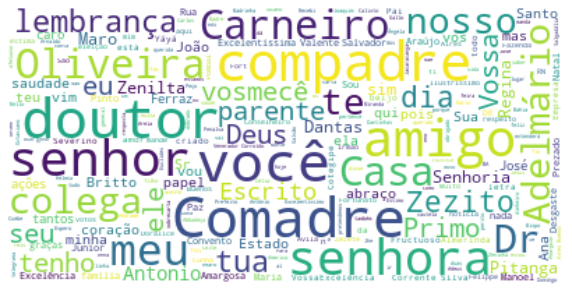

In [47]:
todas = palavras[0]

for i in range(1,50):
    todas.extend(palavras[i])

nuvem = ' '.join(todas)

# Gera a nuvem de palavras
wordcloud = WordCloud().generate(nuvem)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",
                      max_words=len(todas),
                      max_font_size=40, 
                      relative_scaling=.6) \
            .generate(nuvem)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

De forma geral, os tópicos obtidos são pouco informativos. Em todos, prevalecem nomes próprios, números e pronomes, além de haver verbos flexionados e palavras que aparecem capitalizadas e em minúsculas, dificultando a interpretação dos resultados.

### Resultados com remoção de *stop words*, nomes próprios e números

Os passos anteriores foram repetidos, adicionando-se, na criação do corpus do gensim, as opções de remoção de *stop words*, nomes próprios e números, e passagem dos tokens para minúsculas.

In [57]:
dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', metadados.ID, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_rm.md') and \
   os.path.exists('Modelos/corpus_tfidf_rm.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_rm.md')     # carrega o modelo tf-idf
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_rm.cp')            # carrega o corpus tf-idf
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)  # inicialização da trasnformação tf-idf
    corpus_tfidf = modelo_tfidf[corpus_gensim]                       # transformação do corpus
    modelo_tfidf.save('Modelos/modelo_tfidf_rm.md')                  # salve o modelo tf-idf
    MmCorpus.serialize('Modelos/corpus_tfidf_rm.cp', corpus_tfidf)   # salva o corpus tf-idf

if os.path.exists('Modelos/modelo_lsi_100_rm.md') and \
   os.path.exists('Modelos/corpus_lsi_100_rm.cp'):
    modelo_lsi = LsiModel.load('Modelos/modelo_lsi_100_rm.md')       # carrega o modelo lsi
    corpus_lsi = MmCorpus('Modelos/corpus_lsi_100_rm.cp')            # carrega o corpus lsi
else:
    modelo_lsi = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)   # inicialização
    corpus_lsi = modelo_lsi[corpus_tfidf]                                            # transformação do corpus
    modelo_lsi.save('Modelos/modelo_lsi_100_rm.md')                                  # salva o modelo lsi
    MmCorpus.serialize('Modelos/corpus_lsi_100_rm.cp', corpus_lsi)                      # salva o corpus lsi

In [58]:
printmd('**100 primeiras palavras do primeiro tópico identificado:**')
pprint(modelo_lsi.print_topics(num_topics=1, num_words=100)[0][1])

**100 primeiras palavras do primeiro tópico identificado:**

('0.142*"vou" + 0.138*"dia" + 0.133*"amigo" + 0.117*"carta" + '
 '0.115*"lembrança" + 0.107*"saúde" + 0.107*"hoje" + 0.105*"casa" + '
 '0.089*"disse" + 0.087*"abraço" + 0.086*"dias" + 0.085*"família" + '
 '0.085*"desejo" + 0.084*"recebi" + 0.079*"mande" + 0.078*"melhor" + '
 '0.074*"amigos" + 0.074*"notícia" + 0.073*"graças" + 0.073*"vida" + '
 '0.073*"manda" + 0.073*"espero" + 0.070*"coração" + 0.069*"bahia" + '
 '0.069*"notícias" + 0.066*"dinheiro" + 0.066*"dê" + 0.066*"mandar" + '
 '0.065*"querido" + 0.063*"saudade" + 0.063*"lembranças" + 0.063*"resposta" + '
 '0.063*"escrever" + 0.062*"peço" + 0.061*"certo" + 0.061*"fiquei" + '
 '0.061*"amor" + 0.061*"paz" + 0.061*"respeito" + 0.060*"mando" + 0.060*"caso" '
 '+ 0.060*"ano" + 0.059*"alguma" + 0.058*"felicidade" + 0.058*"linha" + '
 '0.058*"ordens" + 0.057*"amiga" + 0.057*"veio" + 0.056*"outro" + '
 '0.056*"cartas" + 0.056*"papel" + 0.056*"prazer" + 0.056*"deu" + '
 '0.055*"votos" + 0.055*"amanhã" + 0.055*"noite" + 0.054*"março" + '


Para facilitar a visualização dos resultados, mostramos abaixo os primeiros 50 tokens dos cinco tópicos iniciais, sem os seus respectivos pesos.

In [59]:
palavras = []

for i in range(50):
    palavras.append([word for (word, load) in modelo_lsi.show_topic(i, 100) if len(word) > 1])
    if i < 5:
        printmd('**Tópico ' + str(i+1) + ':**')
        print(palavras[i][:50])

**Tópico 1:**

['vou', 'dia', 'amigo', 'carta', 'lembrança', 'saúde', 'hoje', 'casa', 'disse', 'abraço', 'dias', 'família', 'desejo', 'recebi', 'mande', 'melhor', 'amigos', 'notícia', 'graças', 'vida', 'manda', 'espero', 'coração', 'bahia', 'notícias', 'dinheiro', 'dê', 'mandar', 'querido', 'saudade', 'lembranças', 'resposta', 'escrever', 'peço', 'certo', 'fiquei', 'amor', 'paz', 'respeito', 'mando', 'caso', 'ano', 'alguma', 'felicidade', 'linha', 'ordens', 'amiga', 'veio', 'outro', 'cartas']


**Tópico 2:**

['lembrança', 'vou', 'mando', 'saudação', 'manda', 'saudade', 'notícia', 'mande', 'linha', 'amigo', 'querido', 'benção', 'qui', 'margem', 'vire', 'papel', 'graças', 'bote', 'menino', 'dê', 'querida', 'vim', 'deus', 'felicidade', 'amor', 'dinheiro', 'pitanga', 'estimado', 'quizer', 'beijo', 'olhe', 'escreva', 'pedido', 'fiquei', 'terminar', 'linhas', 'pego', 'dona', 'vida', 'amiga', 'ordens', 'respeito', 'tendo', 'votos', 'colega', 'criado', 'nomeação', 'consideração', 'barão', 'casa']


**Tópico 3:**

['lembrança', 'amigo', 'lembranças', 'notícia', 'dia', 'mando', 'abraços', 'saudação', 'disse', 'linha', 'hoje', 'saudades', 'dias', 'veio', 'criado', 'saúde', 'colega', 'estima', 'estimado', 'consideração', 'semana', 'amanhã', 'nomeação', 'noite', 'casa', 'pitanga', 'peço', 'benção', 'amigos', 'beija', 'votos', 'bote', 'vire', 'dê', 'pedido', 'gostei', 'parente', 'espaço', 'sábado', 'passar', 'família', 'mandou', 'feira', 'provas', 'felizmente', 'bahia', 'receber', 'outubro', 'amor', 'beijo']


**Tópico 4:**

['amor', 'dinheiro', 'beijo', 'espero', 'notícia', 'casa', 'mando', 'feliz', 'mande', 'abraço', 'nº', 'paz', 'amo', 'lembrança', 'querido', 'saudade', 'endereço', 'disse', 'colega', 'vida', 'mandar', 'gostaria', 'manda', 'ano', 'certo', 'felicidade', 'impressão', 'amiga', 'jovem', 'bahia', 'querida', 'amanhã', 'menino', 'espaço', 'linha', 'sinto', 'negócio', 'pessoal', 'legal', 'veio', 'votos', 'hoje', 'viver', 'postal', 'moto', 'cep', 'fé', 'foto', 'maro', 'ilegível']


**Tópico 5:**

['herdeiros', 'resposta', 'respeito', 'pertence', 'querido', 'abraço', 'reis', 'negócio', 'dia', 'quantia', 'pagar', 'dinheiro', 'notícias', 'constança', 'espero', 'juros', 'receber', 'visitas', 'quiser', 'contas', 'aceite', 'mando', 'agitar', 'agita', 'custas', 'dívida', 'precisões', 'graças', 'mandar', 'julho', 'saúde', 'nº', 'principal', 'possa', 'fl', 'rogar', 'meninos', 'mande', 'horas', 'procuração', 'escreva', 'setembro', 'ações', 'antigo', 'execução', 'mesma', 'gostaria', 'pleito', 'eleição', 'legal']


In [55]:
n_topicos = set(range(5))

for i in list(n_topicos):
    outros = n_topicos - set([i])

    set_outros = set()

    for j in outros:
        set_outros = set_outros.union(palavras[j][:50])
    
    printmd('**Tokens apenas no tópico ' + str(i+1) + ':**')
    print(sorted(set(palavras[i][:50]) - set_outros))

**Tokens apenas no tópico 1:**

['alguma', 'carta', 'cartas', 'caso', 'coração', 'desejo', 'escrever', 'melhor', 'outro', 'recebi']


**Tokens apenas no tópico 2:**

['barão', 'deus', 'dona', 'linhas', 'margem', 'olhe', 'papel', 'pego', 'qui', 'quizer', 'tendo', 'terminar', 'vim']


**Tokens apenas no tópico 3:**

['abraços', 'beija', 'estima', 'feira', 'felizmente', 'gostei', 'mandou', 'noite', 'outubro', 'parente', 'passar', 'provas', 'saudades', 'semana', 'sábado']


**Tokens apenas no tópico 4:**

['amo', 'cep', 'endereço', 'feliz', 'foto', 'fé', 'ilegível', 'impressão', 'jovem', 'maro', 'moto', 'pessoal', 'postal', 'sinto', 'viver']


**Tokens apenas no tópico 5:**

['aceite', 'agita', 'agitar', 'antigo', 'ações', 'constança', 'contas', 'custas', 'dívida', 'eleição', 'execução', 'fl', 'herdeiros', 'horas', 'julho', 'juros', 'meninos', 'mesma', 'pagar', 'pertence', 'pleito', 'possa', 'precisões', 'principal', 'procuração', 'quantia', 'quiser', 'reis', 'rogar', 'setembro', 'visitas']


O conjunto das 100 palavras mais importantes de cada um dos 50 primeiros tópicos foi usado para criar a nuvem de palavras exibida abaixo.

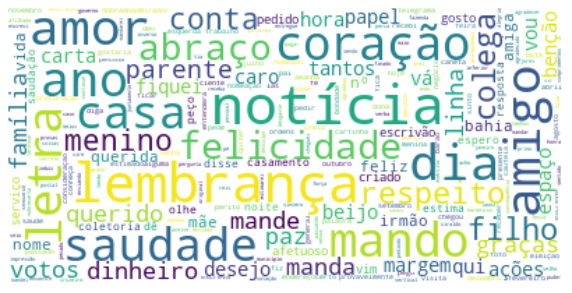

In [56]:
todas = palavras[0]

for i in range(1,50):
    todas.extend(palavras[i])

nuvem = ' '.join(todas)

# Gera a nuvem de palavras
wordcloud = WordCloud().generate(nuvem)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",
                      max_words=len(todas),
                      max_font_size=40, 
                      relative_scaling=.6) \
            .generate(nuvem)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As primeiras 50 palavras dos tópicos gerados incluem diversas palavras em comum, grande parte delas refletindo termos tipicamente encontrados em cartas, como saudações e expressões de cunho afetivo. Embora sua ordenação seja razoavelmente distinta em cada tópico, refletindo diferenças em grau de importância na constituição do tópico, ela não permite diferenciar claramente os significados dos temas.

Apesar disso, pode-se notar uma aparente distinção entre os quatro primeiros tópicos e o quinto:

  - Nos <u>*quatro primeiros tópicos*</u>, predominam palavras tipicamente encontradas em mensagens pessoais entre sujeitos que mantêm algum relacionamento. Neles, há termos, como 'amigo', 'abraço', 'coração', 'querido', 'saudade', 'beijo', e 'amor'.
  - No <u>*quinto tópico*</u>, surgem palavras que podem estar associadas a relações mais formais. Há, inclusive, termos relativos a questões financeiras, como 'herdeiros', 'embolçar', 'quantia', 'dívida', 'juros', 'contas', 'dívida', 'custas'.

### Resultados com lematização

Nesta etapa, além da remoção de *stop words*, nomes próprios e números, e da passagem dos tokens para minúsculas, incluímos a lematização na criação do corpus do gensim.

In [60]:
dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', metadados.ID, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=True, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_lem.md') and \
   os.path.exists('Modelos/corpus_tfidf_lem.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_lem.md')     # carrega o modelo tf-idf
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_lem.cp')            # carrega o corpus tf-idf
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)   # inicialização da trasnformação tf-idf
    corpus_tfidf = modelo_tfidf[corpus_gensim]                        # transformação do corpus
    modelo_tfidf.save('Modelos/modelo_tfidf_lem.md')                  # salve o modelo tf-idf
    MmCorpus.serialize('Modelos/corpus_tfidf_lem.cp', corpus_tfidf)   # salva o corpus tf-idf

if os.path.exists('Modelos/modelo_lsi_100_lem.md') and \
   os.path.exists('Modelos/corpus_lsi_100_lem.cp'):
    modelo_lsi = LsiModel.load('Modelos/modelo_lsi_100_lem.md')       # carrega o modelo lsi
    corpus_lsi = MmCorpus('Modelos/corpus_lsi_100_lem.cp')            # carrega o corpus lsi
else:
    modelo_lsi = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)    # inicialização
    corpus_lsi = modelo_lsi[corpus_tfidf]                                             # transformação do corpus
    modelo_lsi.save('Modelos/modelo_lsi_100_lem.md')                                  # salva o modelo lsi
    MmCorpus.serialize('Modelos/corpus_lsi_100_lem.cp', corpus_lsi)                   # salva o corpus lsi

In [61]:
printmd('**100 primeiras palavras do primeiro tópico identificado:**')
pprint(modelo_lsi.print_topics(num_topics=1, num_words=100)[0][1])

**100 primeiras palavras do primeiro tópico identificado:**

('0.154*"compadrar" + 0.139*"mandar" + 0.128*"dia" + 0.118*"amigar" + '
 '0.112*"suar" + 0.111*"querer" + 0.111*"umar" + 0.109*"cartar" + '
 '0.108*"comer" + 0.105*"vir" + 0.105*"escrever" + 0.105*"lembrança" + '
 '0.104*"ficar" + 0.102*"passar" + 0.101*"pelar" + 0.100*"receber" + '
 '0.099*"casar" + 0.097*"pedir" + 0.094*"haver" + 0.092*"hoje" + '
 '0.091*"saudar" + 0.090*"chegar" + 0.089*"nado" + 0.087*"outro" + '
 '0.086*"amigo" + 0.085*"parir" + 0.084*"notícia" + 0.082*"achar" + '
 '0.080*"algum" + 0.079*"dever" + 0.077*"abraçar" + 0.077*"menino" + '
 '0.076*"esperar" + 0.075*"estimar" + 0.073*"contar" + 0.073*"encontrar" + '
 '0.073*"desejar" + 0.072*"família" + 0.069*"melhor" + 0.068*"saudade" + '
 '0.066*"ano" + 0.066*"sentir" + 0.065*"responder" + 0.064*"continuar" + '
 '0.064*"sobrar" + 0.064*"ordem" + 0.063*"visitar" + 0.063*"deixar" + '
 '0.062*"filho" + 0.062*"linha" + 0.062*"falar" + 0.062*"sair" + 0.061*"vidar" '
 '+ 0.061*"seguir" + 0.060*"enviar" + 0.060*"caro" + 0.060*

Seguem os primeiros 50 tokens dos dez tópicos iniciais, sem os seus respectivos pesos.

In [62]:
palavras = []

for i in range(50):
    palavras.append([word for (word, load) in modelo_lsi.show_topic(i, 100) if len(word) > 1])
    if i < 5:
        printmd('**Tópico ' + str(i+1) + ':**')
        print(palavras[i][:50])

**Tópico 1:**

['compadrar', 'mandar', 'dia', 'amigar', 'suar', 'querer', 'umar', 'cartar', 'comer', 'vir', 'escrever', 'lembrança', 'ficar', 'passar', 'pelar', 'receber', 'casar', 'pedir', 'haver', 'hoje', 'saudar', 'chegar', 'nado', 'outro', 'amigo', 'parir', 'notícia', 'achar', 'algum', 'dever', 'abraçar', 'menino', 'esperar', 'estimar', 'contar', 'encontrar', 'desejar', 'família', 'melhor', 'saudade', 'ano', 'sentir', 'responder', 'continuar', 'sobrar', 'ordem', 'visitar', 'deixar', 'filho', 'linha']


**Tópico 2:**

['compadrar', 'lembrança', 'linha', 'mandar', 'menino', 'saudação', 'botar', 'prezar', 'notícia', 'benção', 'nado', 'dinheiro', 'margem', 'pitanga', 'ciraldo', 'virar', 'qui', 'esquecer', 'graça', 'deus', 'pelar', 'olhar', 'quizer', 'cruzeiro', 'escrever', 'dever', 'vertical', 'haver', 'pedir', 'saudade', 'sobrar', 'algum', 'destá', 'apresentar', 'amigar', 'vidar', 'político', 'querer', 'agradecer', 'nomear', 'consideração', 'colega', 'papel', 'respeitar', 'nomeação', 'agostar', 'dispor', 'criar', 'obrigar', 'interessar']


**Tópico 3:**

['compadrar', 'amigar', 'querido', 'amor', 'gostar', 'saudade', 'beijar', 'lembrança', 'terminar', 'estimar', 'dia', 'amar', 'prezar', 'obrigar', 'menino', 'abraço', 'perguntar', 'nó', 'graça', 'recomendar', 'ordem', 'criar', 'vir', 'apresentar', 'serviço', 'nomeação', 'consideração', 'nomear', 'falar', 'papel', 'mandar', 'namorar', 'querer', 'abraçar', 'passar', 'pelar', 'foto', 'olhar', 'político', 'sentir', 'comprar', 'voto', 'dispor', 'telefonar', 'eleição', 'pedir', 'noite', 'mãe', 'honrar', 'esperar']


**Tópico 4:**

['felicidade', 'amor', 'pagar', 'querido', 'mandar', 'comprar', 'abraçar', 'dia', 'amar', 'desejar', 'compadrar', 'dinheiro', 'vidar', 'paz', 'nó', 'amigar', 'saudar', 'feliz', 'sincero', 'coração', 'lembrança', 'colega', 'estimar', 'prazer', 'amanhã', 'negócio', 'hoje', 'linha', 'sair', 'procuração', 'contar', 'voto', 'vir', 'aceitar', 'casar', 'telefonar', 'semana', 'estevar', 'rei', 'esquecer', 'haver', 'saudação', 'margem', 'irar', 'abraço', 'fé', 'respeitar', 'chegar', 'alegria', 'pé']


**Tópico 5:**

['compadrar', 'lembrança', 'gostar', 'espero', 'nº', 'saudar', 'conhecer', 'namorar', 'graça', 'ano', 'foto', 'linha', 'menino', 'falar', 'legal', 'estudar', 'aceitar', 'amor', 'endereçar', 'bahia', 'benção', 'trabalhar', 'estimar', 'salvador', 'moto', 'fortaleza', 'fazenda', 'tio', 'espaçar', 'abraçar', 'estudo', 'vender', 'certar', 'gozar', 'conseguir', 'deus', 'dono', 'postal', 'notícia', 'maro', 'papel', 'nome', 'adelmário', 'mandar', 'filho', 'dobrar', 'afilhar', 'respeitar', 'felicidade', 'aula']


In [63]:
n_topicos = set(range(5))

for i in list(n_topicos):
    outros = n_topicos - set([i])

    set_outros = set()

    for j in outros:
        set_outros = set_outros.union(palavras[j][:50])
    
    printmd('**Tokens apenas no tópico ' + str(i+1) + ':**')
    print(sorted(set(palavras[i][:50]) - set_outros))

**Tokens apenas no tópico 1:**

['achar', 'amigo', 'cartar', 'comer', 'continuar', 'deixar', 'encontrar', 'família', 'ficar', 'melhor', 'outro', 'parir', 'receber', 'responder', 'suar', 'umar', 'visitar']


**Tokens apenas no tópico 2:**

['agostar', 'agradecer', 'botar', 'ciraldo', 'cruzeiro', 'destá', 'interessar', 'pitanga', 'qui', 'quizer', 'vertical', 'virar']


**Tokens apenas no tópico 3:**

['beijar', 'eleição', 'honrar', 'mãe', 'noite', 'perguntar', 'recomendar', 'serviço', 'terminar']


**Tokens apenas no tópico 4:**

['alegria', 'amanhã', 'coração', 'estevar', 'feliz', 'fé', 'irar', 'negócio', 'pagar', 'paz', 'prazer', 'procuração', 'pé', 'rei', 'sair', 'semana', 'sincero']


**Tokens apenas no tópico 5:**

['adelmário', 'afilhar', 'aula', 'bahia', 'certar', 'conhecer', 'conseguir', 'dobrar', 'dono', 'endereçar', 'espaçar', 'espero', 'estudar', 'estudo', 'fazenda', 'fortaleza', 'gozar', 'legal', 'maro', 'moto', 'nome', 'nº', 'postal', 'salvador', 'tio', 'trabalhar', 'vender']


O conjunto das 100 palavras mais importantes de cada um dos 50 primeiros tópicos foi usado para criar a nuvem de palavras exibida abaixo.

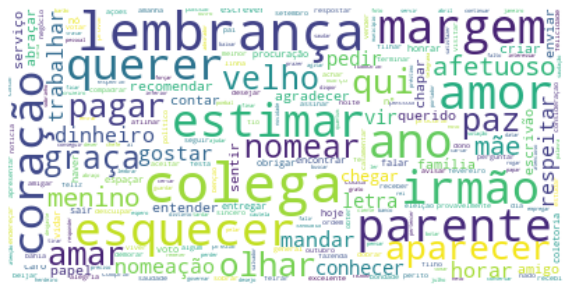

In [64]:
todas = palavras[0]

for i in range(1,50):
    todas.extend(palavras[i])

nuvem = ' '.join(todas)

# Gera a nuvem de palavras
wordcloud = WordCloud().generate(nuvem)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",
                      max_words=len(todas),
                      max_font_size=40, 
                      relative_scaling=.6) \
            .generate(nuvem)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

O modelo de lematização em português da biblioteca spaCy claramente apresenta problemas. Diversos substantivos parecem ter sido transformados em verbos incorretamente, como 'amiga' para 'amigar', 'carta' para 'cartar', 'casa' para 'casar', e 'beijo' para 'beijar'. Os resultados reportados em artigos e blogs confirmam essa limitação, que parece não ser não intensa para a língua inglesa (ex. https://lars76.github.io/nlp/lemmatize-portuguese/; https://towardsdatascience.com/state-of-the-art-multilingual-lemmatization-f303e8ff1a8).

Dado que a implementação da lematização gerou tópicos menos claros do que os obtidos anteriormente, o método não será utilizado nas análises seguintes. 

### Variações nos tópicos ao longo do tempo

Os quatro períodos definidos anteriormente (1823-1890, 1890-1920, 1920-1950 e 1950-2000) foram usados para dividir os textos em quatro corpora. Para cada um deles, repetimos a análise com o modelo LSI e a opção de remoção de *stop words* e nomes próprios, lematização, e passagem para minúsculas.

**Criação dos corpora e dos modelos LSI:**

In [336]:
anos = metadados.Data.str.slice(start=6)

IDs_1890 = metadados.ID[anos <= '1890']
IDs_1920 = metadados.ID[anos.between('1891', '1920', inclusive = True)]
IDs_1950 = metadados.ID[anos.between('1921', '1950', inclusive = True)]
IDs_2000 = metadados.ID[anos > '1950']

In [77]:
# 1823-1890:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_1890, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_1890.md') and \
   os.path.exists('Modelos/corpus_tfidf_1890.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_1890.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_1890.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_1890.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_1890.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_1890.md') and \
   os.path.exists('Modelos/corpus_lsi_100_1890.cp'):
    modelo_lsi_1890 = LsiModel.load('Modelos/modelo_lsi_100_1890.md')
    corpus_lsi_1890 = MmCorpus('Modelos/corpus_lsi_100_1890.cp')
else:
    modelo_lsi_1890 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_1890 = modelo_lsi[corpus_tfidf]
    modelo_lsi_1890.save('Modelos/modelo_lsi_100_1890.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_1890.cp', corpus_lsi)

In [73]:
# 1890-1920:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_1920, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_1920.md') and \
   os.path.exists('Modelos/corpus_tfidf_1920.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_1920.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_1920.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_1920.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_1920.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_1920.md') and \
   os.path.exists('Modelos/corpus_lsi_100_1920.cp'):
    modelo_lsi_1920 = LsiModel.load('Modelos/modelo_lsi_100_1920.md')
    corpus_lsi_1920 = MmCorpus('Modelos/corpus_lsi_100_1920.cp')
else:
    modelo_lsi_1920 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_1920 = modelo_lsi[corpus_tfidf]
    modelo_lsi_1920.save('Modelos/modelo_lsi_100_1920.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_1920.cp', corpus_lsi_1920)

In [74]:
# 1920-1950:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_1950, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_1950.md') and \
   os.path.exists('Modelos/corpus_tfidf_1950.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_1950.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_1950.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_1950.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_1950.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_1950.md') and \
   os.path.exists('Modelos/corpus_lsi_100_1950.cp'):
    modelo_lsi_1950 = LsiModel.load('Modelos/modelo_lsi_100_1950.md')
    corpus_lsi_1950 = MmCorpus('Modelos/corpus_lsi_100_1950.cp')
else:
    modelo_lsi_1950 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_1950 = modelo_lsi[corpus_tfidf]
    modelo_lsi_1950.save('Modelos/modelo_lsi_100_1950.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_1950.cp', corpus_lsi_1950)

In [75]:
# 1950-2000:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_2000, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_2000.md') and \
   os.path.exists('Modelos/corpus_tfidf_2000.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_2000.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_2000.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_2000.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_2000.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_2000.md') and \
   os.path.exists('Modelos/corpus_lsi_100_2000.cp'):
    modelo_lsi_2000 = LsiModel.load('Modelos/modelo_lsi_100_2000.md')
    corpus_lsi_2000 = MmCorpus('Modelos/corpus_lsi_100_2000.cp')
else:
    modelo_lsi_2000 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_2000 = modelo_lsi[corpus_tfidf]
    modelo_lsi_2000.save('Modelos/modelo_lsi_100_2000.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_2000.cp', corpus_lsi_2000)

<br>**Identificação dos tópicos:**

Abaixo, listamos , para cada período, os primeiros 30 tokens dos cinco tópicos iniciais, sem os respectivos pesos.

In [78]:
modelos = [modelo_lsi_1890, modelo_lsi_1920, modelo_lsi_1950, modelo_lsi_2000]
n_topicos = set(range(1,6))
periodos = ['1823-1890', '1891-1920', '1921-1950', '1951-2000']

topicos = pd.DataFrame(index=n_topicos, columns=periodos)
unicos = pd.DataFrame(index=n_topicos, columns=periodos)
comuns = []

for periodo, modelo in zip(periodos, modelos):
    for i in n_topicos:
        topicos.loc[i, periodo] = [token for (token, carga)
                                   in modelo.show_topic(i-1, 30)
                                   if len(token)>1]
        unicos.loc[i, periodo] = set(topicos.loc[i, periodo])
        comuns.extend(topicos.loc[i, periodo])

printmd('<br>**Tópicos iniciais para cada período:**')    
topicos

<br>**Tópicos iniciais para cada período:**

,1823-1890,1891-1920,1921-1950,1951-2000
1,"[amigo, respeito, saúde, carta, resposta, hoje, melhor, casa, dia, ordens, vou, coração, criado, recebi, setembro, negócio, passado, família, alguma, disse, desejo, mandar, dias, conta, estima, consideração, tendo, barão, mesma, herdeiros]","[dia, carta, hoje, amigos, família, eleição, notícias, recebi, disse, saúde, casa, amigo, melhor, barão, visitas, dias, ações, creio, tendo, vou, ordens, telegrama, votos, chegou, desejo, filho, sendo, cartas, peço, horas]","[amigo, dia, carta, hoje, dias, casa, abraço, lembranças, disse, caso, parente, peço, recebi, família, saúde, abraços, saudades, bahia, amigos, vou, nome, pedido, escrivão, melhor, desejo, notícias, colega, mandar, escrever, nomeação]","[lembrança, vou, dia, notícia, saúde, amigo, querido, carta, amor, manda, vida, graças, desejo, casa, mande, saudade, mando, espero, hoje, abraço, felicidade, linha, dinheiro, beijo, saudação, fiquei, benção, qui, paz, bahia]"
2,"[pertence, herdeiros, reis, pagar, agita, custas, agitar, constança, juros, precisões, pleito, execução, rogar, quantia, antigo, principal, pesar, fl, continuação, embolçar, té, resposta, farei, mestre, reais, continuar, atenciosa, atualmente, resto, julho]","[ações, letras, cautela, cautelas, telegrama, procuração, cumprimentos, procurações, lista, operação, conforme, nº, transferências, afetuoso, afetuosos, pessoas, banco, debêntures, substituição, assembléia, transferidas, dedicado, bancos, notícias, votos, juros, visitas, amizade, ministro, bahia]","[amigo, casa, lembranças, abraços, nomeação, parente, colega, saudades, pedido, dia, escrivão, coletoria, caro, família, cargo, ordens, amiga, noite, dias, grato, disse, vestido, amanhã, dedicada, vou, admirador, distinto, hoje, guarda, cousa]","[lembrança, notícia, mando, saudação, linha, benção, vire, mande, estimado, qui, bote, pitanga, menino, manda, dinheiro, hoje, bahia, saúde, disse, escreva, espero, ciraldo, nº, linhas, dias, pessoal, dê, deus, agosto, vim]"
3,"[entenderá, contas, resposta, conta, respeito, conheça, perca, envio, falar, perito, amigo, ajunto, devagar, aver, carecer, estima, guardar, espaço, las, consideração, mandarei, enviado, fiz, vamos, creio, procurarei, entregue, digo, cópia, dívida]","[ações, colega, cautelas, cautela, força, consideração, estima, lista, outubro, peço, proteção, honra, amiga, criado, caro, fanáticos, pessoas, procurações, transferidas, admirador, forças, lembrança, semana, subscrevo, vou, adversários, grato, servir, assembléia, pedido]","[cousa, amor, palavras, sinto, cousas, abraços, lembranças, vida, cartas, presente, coletoria, havia, cabeça, poderia, meninos, escrivão, abraço, ilhéus, franqueza, disse, pessoal, vir, frase, velhinha, sentir, espírito, dúvida, bilhete, pensar, nomeação]","[amor, disse, dinheiro, hoje, casa, veio, pé, beijo, feliz, amo, endereço, notícia, havia, mandar, impressão, querida, saudade, dias, amanhã, felicidade, vida, comprar, mando, ficou, beija, radiografia, coração, viver, felizmente, certo]"
4,"[entenderá, conheça, perca, conta, enviado, perito, contas, cópia, envio, las, recebi, vamos, aver, carecer, respeito, preciso, mesma, engoliu, substitui, diligências, frustadas, alcancar, vagarosas, conheca, pílula, devagar, feira, deveria, espaço, procurarei]","[amiga, ações, bahia, manda, aperto, lembrança, alegria, adversários, vou, sinceras, creio, amigos, notícias, afilhada, bens, vire, dona, passamos, pequeno, regularmente, coração, mão, aceitando, beijo, benção, eleição, pedido, servir, apuração, graças]","[colega, amigos, distinto, agradecer, município, estima, admirador, venho, prazer, oferta, atenção, parente, bahia, nome, gentileza, pombal, conferência, política, tendo, sido, pretenção, bondade, eleitores, caso, juntamente, delicada, visita, digno, termo, atencioso]","[fé, enviando, amigo, mando, sinceramente, aceite, notícia, bahia, sincero, querido, viver, aseite, querida, tranquilidade, dia, escreva, gosando, beijo, nº, família, moti

Em seguida, apresentamos os tokens que aparecem apenas em cada tópico do conjunto de tópicos para cada período.

In [79]:
for periodo in periodos:
    for i in n_topicos:
        outros = n_topicos - set([i])
        set_outros = set()
        for j in outros:
            set_outros = set_outros.union(topicos.loc[j,periodo])
        unicos.loc[i, periodo] = sorted(set(topicos.loc[i, periodo]) - set_outros)
        
printmd('<br>**Tokens únicos em cada tópico por período:**')    
unicos

<br>**Tokens únicos em cada tópico por período:**

,1823-1890,1891-1920,1921-1950,1951-2000
1,"[alguma, barão, carta, casa, coração, criado, desejo, dia, dias, disse, família, hoje, mandar, melhor, negócio, ordens, passado, saúde, setembro, tendo, vou]","[amigo, barão, carta, cartas, casa, chegou, desejo, dia, dias, disse, família, filho, hoje, horas, melhor, ordens, recebi, saúde, sendo, tendo]","[carta, desejo, escrever, mandar, melhor, notícias, peço, recebi, saúde]","[carta, desejo, fiquei, graças, paz]"
2,"[agita, agitar, antigo, atenciosa, atualmente, constança, continuar, continuação, custas, embolçar, execução, farei, fl, julho, juros, mestre, pagar, pertence, pesar, pleito, precisões, principal, quantia, reais, reis, resto, rogar, té]","[afetuoso, afetuosos, amizade, banco, bancos, conforme, cumprimentos, debêntures, dedicado, juros, letras, ministro, nº, operação, procuração, substituição, transferências]","[amanhã, amiga, dedicada, grato, noite, vestido]","[agosto, bote, ciraldo, deus, estimado, linhas, menino, pessoal, pitanga, vim, vire]"
3,"[ajunto, creio, digo, entregue, fiz, guardar, mandarei]","[admirador, caro, colega, consideração, criado, estima, força, grato, honra, outubro, proteção, semana, subscrevo]","[amor, bilhete, cabeça, cartas, cousas, dúvida, espírito, franqueza, frase, havia, ilhéus, meninos, palavras, pensar, pessoal, poderia, presente, sentir, sinto, velhinha, vida, vir]","[amanhã, amo, beija, certo, comprar, coração, feliz, felizmente, ficou, havia, impressão, mandar, pé, radiografia, veio]"
4,"[deveria, feira, preciso]","[aceitando, afilhada, apuração, beijo, bens, benção, coração, graças, passamos, pequeno, regularmente]","[agradecer, atencioso, atenção, bondade, delicada, digno, gentileza, juntamente, oferta, política, prazer, pretenção, sido, tendo, termo, venho, visita]","[aceite, ardente, aseite, demoro, enviando, família, gosando, guanabara, motivo, máxima, palavras, queridinha, sinceramente, tranquilidade]"
5,"[anotação, cobrança, comprar, dissesse, dorso, encarregar, enviada, inclinadamente, incluza, indicando, pense, posta, página, quisera, regressarei]","[abraço, aceite, capitão, cargas, conselheiro, coronel, diversos, dê, feridos, fogo, jagunços, legais, luta, mortos, oficiais, papel, soldados]","[coletor, concurso, desdobramento, efetivo, espontâneo, fiscal, gabinete, hipótese, interino, mando, manos, nomeado, oferecimento, podendo, saudações]","[agradecido, amigos, ano, candidato, caro, chapas, coluna, cruzeiro, entregue, euclides, fazenda, letra, mãe, olhe, sábado, velho, verba, votação, votos, vá]"


**Interpretação dos resultados:**

A separação da análise por período parece ter ajudado a distinguir melhor os tópicos gerados pelo modelo LSI. Chegamos às seguintes conclusões:

  - Todos os tópicos do período de **1823 a 1890** incluem termos mais formais, muitos deles aparentemente relativos a transações comerciais ou oficiais (ex., ofício, negócio, procuração, execução, embolçar). 
      - O <u>*primeiro tópico*</u> é pouco específico, remetendo a palavras que tipicamente esperamos encontrar numa carta, além de termos como 'barão' e 'herdeiros'.
      - No <u>*segundo tópico*</u>, surgem palavras que remetem a questões financeiras, como 'pagar', 'quantia', 'custos', e 'juros'.
      - Os <u>*tópicos seguintes*</u> misturam tokens dos anteriores, deles pouco se distinguindo.
  
  - Os tópicos do período de **1890 a 1920** foram os que apresentaram diferenças mais claras entre si. Os termos formais ainda predominam, embora apareçam palavras tais como 'coração' e 'beijo'. Aparecem também temas relacionados aos conflitos no cangaço e a disputas políticas.
     - Novamente, o <u>*primeiro tópico*</u> inclui termos genéricos, comuns a vários tipos de carta. A exceção é o termo 'eleição', que está presente em três dos tópicos desse período. Isso parece ser coerente a história do Brasil, dado que o período compreende as primeiras décadas da recém-criada República.
     - O <u>*segundo tópico*</u> está claramente associado a questões financeiras, como pagamentos e dívidas. Nele, destacam-se palavras tais como 'cautela', 'procuração', 'operação', 'transferências', 'debêntures', 'banco', e 'juros'.
     - No <u>*terceiro e quarto tópicos*</u>, em meio a termos mais gerais, em tom mais pessoal (ex., 'afilhada', 'coração', 'beijo', 'benção', e 'abraço'), destacam-se termos aparentemente associados à política, como 'adversários', 'assembléia', 'apuração, e 'eleição'.
     - O <u>*quinto tópico*</u> se distingue pelos termos que remetem aos conflitos no cangaço que marcaram a época, como 'mortos', 'feridos', 'soldados', 'luta', 'fogo', 'jagunços', 'coronel', e 'capitão'.
  
  - No período de **1920 a 1950**, os tópicos são pouco distintos. Em geral, percebe-se um uma maior ocorrência de termos relacionados a questões oficiais, como 'escrivão', 'cargo', 'nomeação', e 'concurso'.
    - Nos <u>*três primeiros tópicos*</u> predominam termos comumente encontrados em cartas pessoais, como 'amigo', 'abraço', 'família', e 'saudades'. Destes, o terceiro é o que inclui palavras mais informais, tais como 'amor', e 'velhinha'.
    - O <u>*quarto tópico*</u> parece refletir a gratidão do rementente, com destaque para as palavras 'agradecer', 'atencioso', 'atenção', 'bondade', e 'gentileza'. Além disso, parece retormar questões políticas, em função da inclusão de palavras tais como 'município', 'conferência', 'política', 'pretenção', e 'eleitores'.
    - O <u>*quinto tópico*</u> é o que está mais fortemente associado a questões oficiais e políticas. Nele, destacam-se os termos 'coletor', 'concurso', 'fiscal', 'gabinete', 'interino', e 'nomeado'.
  
  - Por fim, entre **1950 e 2000**, os primeiros quatro tópicos tratam essencialmente de questões pessoais, e o quinto, de questões políticas.
    - Nos <u>*quatro primeiros tópicos*</u>, aparecem referências a relacionamentos afetivos, com palavras tais como 'amor', 'coração', e 'beijo', além de referências a 'dinheiro'. Não se percebe uma distinção clara entre eles.
    - O <u>*quinto tópico*</u> de diferencia pela presença de termos relacionados a questões políticas, como 'candidato', 'chapas', 'verba', e 'votação'.
    - É possível que essas características estejam relacionadas à intensificação da migração do Nordeste para o Sudeste, à perseguição política à época da ditadura, e à redemocratização do país.
    

## Análise semântica

Na segunda etapa da análise, investigamos mudanças no significado das palavras do corpus com o modelo [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) implementado na biblioteca [gensim](https://radimrehurek.com/gensim/models/word2vec.html). Radim Řehůřek, autor do gensim, elaborou um tutorial com mais detalhes sobre a implementação do Word2Vec na biblioteca e exemplos do seu uso (https://rare-technologies.com/word2vec-tutorial/). 

A implementação do gensim permite que as frases que compõem os documentos sejam alimentadas uma a uma, de forma a otimizar a memória. Adaptamos a classe GensimCorpus criada anteriormente para tirar proveito dessa funcionalidade.

In [364]:
class Word2VecCorpus:
    def __init__(self, pasta, IDs, sufixo, stop_words, lower=True, lema=False, nomes=False, num=False):
        self.pasta = pasta
        self.IDs = IDs
        self.sufixo = sufixo
        self.stop = stop_words
        self.lower = lower
        self.lema = lema
        self.nomes = nomes
        self.num = num

    def __iter__(self):
        for counter, id in enumerate(self.IDs):
            fileid = self.pasta + id + self.sufixo
            with open(fileid, mode="r", encoding="utf-8") as doc:
                linhas = doc.readlines()
            
            for linha in linhas:
                linha = nlp(linha.strip('\n'))
                
                if self.nomes and not self.lema:
                    tokens = [token.orth_ for token in linha if token.pos_ != 'PROPN']
                elif self.lema and not self.nomes:
                    tokens = [token.lemma_ for token in linha]
                elif self.nomes and self.lema:
                    tokens = [token.lemma_ for token in linha if token.pos_ != 'PROPN']
                else:
                    tokens = [token.orth_ for token in linha]

                if self.lower:
                    tokens = [token.lower() for token in tokens]
                
                tokens = [token for token in tokens if len(token) > 1 and token not in self.stop]

                if self.num:
                    tokens = [re.sub('[$:0-9]*', '', token) 
                              for token in tokens]
                    tokens = [token for token in tokens if len(token) > 1]
                
                if len(tokens) > 0:
                    yield tokens

### Análise de todo o corpus

Primeiramente, realizamos a análise para todos os documentos do corpus, sem dividi-los por período. O corpus do modelo Word2Vec foi criado com as opções de remoção de *stop words*, nomes próprios e números, e passagem para minúsculas.

In [327]:
corpus_w2v = Word2VecCorpus('CE-DOHS-proc/', metadados.ID, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)
if os.path.exists('Modelos/modelo_w2v.md'):
    modelo_w2v = Word2Vec.load('Modelos/modelo_w2v.md')
else:
    modelo_w2v = Word2Vec(sentences=corpus_w2v, workers=32, batch_words=200)
    modelo_w2v.save('Modelos/modelo_w2v.md')

vocab_w2v = list(modelo_w2v.wv.vocab.keys())

In [165]:
mais_freq = modelo_w2v.wv.index2entity[:500]
menos_freq = modelo_w2v.wv.index2entity[-500:]

Para cada palavra nas 500 mais frequentes no vocabulário do nosso corpus, identificamos as cinco palavras mais similares a ela, usando o modelo Word2Vec. Os resultados são mostrados no dataframe a seguir, onde:

  - **Token:** token dentre os 500 mais frequentes no corpus
  - **Frequência:** número de vezes que a palavra aparece nos tópicos identificados com o modelo LSI sem lematização
  - **Similares:** cinco palavras mais similares ao token, obtidas com o modelo Word2Vec

In [166]:
similares = pd.DataFrame(columns=['Token', 'Frequência', 'Similares'])

tokens = mais_freq

for token in tokens:
    similares = similares.append({'Token': token,
                                  'Frequência': comuns.count(token),
                                  'Similares': [similar for (similar, carga) 
                                                in modelo_w2v.wv.most_similar(token, topn=5)]},
                                 ignore_index=True)

similares = similares.sort_values(by=['Frequência'], ascending=False)
similares

,Token,Frequência,Similares
0,amigo,8,"[coração, ordens, conta, velho, certo]"
4,vou,8,"[casa, vida, notícia, melhor, escrever]"
21,bahia,8,"[ofício, meninos, palavras, querida, fazendo]"
3,hoje,7,"[tendo, disse, dias, casa, caso]"
8,disse,7,"[amigos, dia, tendo, dias, hoje]"
...,...,...,...
239,ai,0,"[notícias, dia, tendo, ocasião, portador]"
238,satisfação,0,"[tendo, sendo, dias, veio, ficar]"
236,bons,0,"[alguma, tendo, confiança, dias, junto]"
235,homem,0,"[amigos, sendo, anos, caso, peço]"


Em seguida, exibimos as mesmas informações para dez palavras selecionadas aleatoriamente dentre as 500 <u>mais frequentes</u> no corpus.

In [172]:
similares = pd.DataFrame(columns=['Token', 'Frequência', 'Similares'])

tokens = [mais_freq[i] for i in sample(range(0, 499), 10)]

for token in tokens:
    similares = similares.append({'Token': token,
                                  'Frequência': comuns.count(token),
                                  'Similares': [similar for (similar, carga) 
                                                in modelo_w2v.wv.most_similar(token, topn=5)]},
                                 ignore_index=True)

similares.sort_values(by=['Token'])

,Token,Frequência,Similares
3,agradecer,1,"[caso, peço, força, melhor, vou]"
0,ai,0,"[notícias, dia, tendo, ocasião, portador]"
6,cópia,2,"[pedido, eleição, caso, feito, causa]"
5,irmão,0,"[outro, casa, vida, tendo, dia]"
2,lembro,0,"[havia, peço, certo, casa, dia]"
8,mundo,0,"[caso, pessoa, acho, fazendo, modo]"
7,sabendo,0,"[tendo, horas, peço, hoje, vida]"
9,saudade,3,"[casa, fazendo, amigos, nome, filho]"
1,tantos,0,"[hoje, caso, pessoa, outro, amigos]"
4,terra,0,"[dia, tendo, vida, mesma, caso]"


Por fim, mostramos cinco palavras mais similares a dez palavras selecionadas aleatoriamente dentre as 500 <u>menos frequentes</u> no corpus.

In [169]:
similares = pd.DataFrame(columns=['Token', 'Frequência', 'Similares'])

tokens = [menos_freq[i] for i in sample(range(0, 499), 10)]

for token in tokens:
    similares = similares.append({'Token': token,
                                  'Frequência': comuns.count(token),
                                  'Similares': [similar for (similar, carga) 
                                                in modelo_w2v.wv.most_similar(token, topn=5)]},
                                 ignore_index=True)

similares.sort_values(by=['Token'])

,Token,Frequência,Similares
7,acrescentar,0,"[precisa, candidatos, esperança, mando, salvo]"
0,alferes,0,"[domingo, passar, feito, igual, venha]"
8,assegurar,0,"[flores, emprego, candidato, continue, velha]"
4,comida,0,"[código, expor, fiscal, notas, visitar]"
3,correndo,0,"[pensar, gesto, cunhado, cavalo, memória]"
9,entregalista,0,"[responda, novembro, lista, pé, escrita]"
5,lavar,0,"[comunicando, disposto, cidadão, enviar, deixo]"
2,moradores,0,"[terreno, parente, recurso, ouvi, aparecer]"
1,prisões,0,"[permita, colega, despesas, praças, indo]"
6,tirou,0,"[necessário, vendo, intermédio, atenção, fé]"


Os resultados foram, em sua grande maioria, insatisfatórios. Para alguns dos termos, o modelo Word2Vec foi capaz de identificar outros que parecem realmente estar a eles associados no contexto tratado no corpus (ex., para 'fiel', gerou as palavras 'amigo', 'velho', 'beijo', e 'coração'; para 'saudade', gerou 'casa', 'amigos', e 'filho'). Contudo, em geral, os termos identificados não parecem ter o mesmo sentido que o termo-alvo da análise (ex. para 'irmão', gerou 'outro', 'casa', 'vida', 'tendo', e 'dia'; para 'comida', gerou 'código', 'expor', 'fiscal', 'notas', e 'visitar'.

O problema pareceu independer da frequência com que o termo-alvo da análise aparecia nos assuntos identificados com o modelo LSI.

### Análise por período

Um dos parâmetro do algoritmo do Word2Vec é o tamanho do lote (*batch_size*). De acordo com [Li et al. (2019)](https://link.springer.com/article/10.1007/s41019-019-0096-6):

  - *Scaling often results in low-quality of learned embeddings or suboptimal GPU utilization. 
The main challenge is batch size. More precisely, when large batch size is applied, the 
embeddings’ quality drops dramatically. If we reduce the batch size, the training speed 
drops dramatically. There is always a trade-off between effectiveness and efficiency.*

Na análise do corpus segmentado por períodos usando a configuração padrão do gensim, foram gerados alertas sugerindo a diminuição dos valores do *batch* em função da subutilização dos *cores* da CPU na criação do corpus do Word2Vec. Após várias reduções, chegamos ao valor de 200, que não gerou mais alertas. Esse valor é próximo da mediana do número de palavras nos documentos pré-processados do corpus, que foi de 210.

In [325]:
batch = 200   # configuração do parâmetro batch_size

In [365]:
corpus_w2v_1890 = Word2VecCorpus('CE-DOHS-proc/', IDs_1890, '-proc.txt', stop_words=stopwords,
                                 lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_1890.md'):
    modelo_w2v_1890 = Word2Vec.load('Modelos/modelo_w2v_1890.md')
else:
    modelo_w2v_1890 = Word2Vec(sentences=corpus_w2v_1890, workers=32, batch_words=batch)
    modelo_w2v_1890.save('Modelos/modelo_w2v_1890.md')

vocab_w2v_1890 = list(modelo_w2v_1890.wv.vocab.keys())

In [366]:
corpus_w2v_1920 = Word2VecCorpus('CE-DOHS-proc/', IDs_1920, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_1920.md'):
    modelo_w2v_1920 = Word2Vec.load('Modelos/modelo_w2v_1920.md')
else:
    modelo_w2v_1920 = Word2Vec(sentences=corpus_w2v_1920, workers=32, batch_words=batch)
    modelo_w2v_1920.save('Modelos/modelo_w2v_1920.md')

vocab_w2v_1920 = list(modelo_w2v_1920.wv.vocab.keys())

In [367]:
corpus_w2v_1950 = Word2VecCorpus('CE-DOHS-proc/', IDs_1950, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_1950.md'):
    modelo_w2v_1950 = Word2Vec.load('Modelos/modelo_w2v_1950.md')
else:
    modelo_w2v_1950 = Word2Vec(sentences=corpus_w2v_1950, workers=32, batch_words=batch)
    modelo_w2v_1950.save('Modelos/modelo_w2v_1950.md')

vocab_w2v_1950 = list(modelo_w2v_1950.wv.vocab.keys())

In [368]:
corpus_w2v_2000 = Word2VecCorpus('CE-DOHS-proc/', IDs_2000, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_2000.md'):
    modelo_w2v_2000 = Word2Vec.load('Modelos/modelo_w2v_2000.md')
else:
    modelo_w2v_2000 = Word2Vec(sentences=corpus_w2v_2000, workers=32, batch_words=batch)
    modelo_w2v_2000.save('Modelos/modelo_w2v_2000.md')

vocab_w2v_2000 = list(modelo_w2v_2000.wv.vocab.keys())

In [588]:
palavras = ['felicidade', 'saudades', 'velho', 'velha', 'homem', 'mulher', 'filhos', 'parente', 'morte']
modelos = [modelo_w2v_1890, modelo_w2v_1920, modelo_w2v_1950, modelo_w2v_2000]
vocabs = [vocab_w2v_1890,vocab_w2v_1920, vocab_w2v_1950, vocab_w2v_2000]
periodos = ['1823-1890', '1891-1920', '1921-1950', '1951-2000']

similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000'])
similares.Palavra = palavras

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in palavras:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ''
similares

,Palavra,1823-1890,1891-1920,1921-1950,1951-2000
0,felicidade,,"[casamento, estima, carta, mesma, tendo]","[carta, colega, tendo, mesma, estima]","[carta, saúde, vou, lembrança, dia]"
1,saudades,"[sofrido, horas, tempos, antigo, dito]","[horas, chegar, alguma, tendo, ano]","[caso, hoje, carta, amigo, tendo]","[chegar, vou, diga, dia, gente]"
2,velho,"[ultimamente, generais, referido, vitória, outubro]","[hoje, saúde, eleição, tendo, carta]","[hoje, caso, escrivão, situação, interesse]","[noite, vou, deus, notícia, hoje]"
3,velha,"[capitão, incluso, principal, duvido, voltar]","[honra, ia, capitão, vila, ministro]","[caso, dias, melhor, escrivão, recebi]","[flores, ia, perguntar, recebi, melhor]"
4,homem,"[sendo, votação, anos, amigos, procurar]","[sendo, amigos, feira, anos, conta]","[situação, sendo, anos, junto, amigos]","[espaço, gente, sentindo, amigos, sendo]"
5,mulher,"[apresentar, filhos, capital, tendo, venha]","[tendo, casa, família, saúde, dando]","[apresentar, mãos, tendo, sincera, falei]",
6,filhos,"[política, feito, quantia, demora, escrevi]","[carta, dia, feito, soube, sido]","[política, pequeno, mulher, divisão, ficamos]","[vá, cartas, aceite, venha, política]"
7,parente,"[paraguaios, dívida, dever, governador, vista]","[secretário, beijo, pé, termos, compra]","[hoje, recebi, dias, colega, amigo]","[compra, curso, verba, tirei, andar]"
8,morte,"[senado, mão, resposta, voluntários, anos]","[resposta, anos, notícias, caso, feito]","[agradecimento, afetuoso, encontramos, passou, saiu]","[vire, benção, contente, mão, saiu]"


In [518]:
palavras = ['interesse', 'cargo', 'governo', 'governador', 'presidente', 'país', 'seca']

similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000'])
similares.Palavra = palavras

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in palavras:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ''
similares

,Palavra,1823-1890,1891-1920,1921-1950,1951-2000
0,interesse,"[casa, carta, nomeação, veio, voto]","[carta, casa, tendo, dia, veio]","[carta, situação, amigo, escrever, casa]","[casa, carta, veio, escrever, vida]"
1,cargo,"[política, boas, carta, pessoa, espero]","[política, carta, visitas, eleição, tendo]","[política, carta, caso, amigo, dias]",
2,governo,"[algum, acha, amigos, dias, dúvida]","[dia, tendo, amigos, carta, eleição]","[dias, amigos, acha, tendo, quase]","[gostaria, sair, quase, amigos, paqueras]"
3,governador,"[noite, seca, resta, sentido, haver]","[noite, dia, vista, desejo, notícias]","[seca, formidável, noite, ha, sentido]",
4,presidente,"[ler, entender, bons, li, ficará]","[ações, ordem, tendo, viagem, entender]","[ler, bons, efetivo, ordem, entender]",
5,país,"[serviço, conta, caso, empregado, alguma]","[serviço, alto, pedido, gente, noite]",,
6,seca,"[eleitores, polícia, governador, hoje, principal]","[hoje, eleição, dias, tendo, deu]","[eleitores, hoje, dias, interesse, água]",


In [582]:
palavras = ['luta', 'guerra', 'capitão', 'coronel', 'general']

similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000'])
similares.Palavra = palavras

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in palavras:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ''
similares

,Palavra,1823-1890,1891-1920,1921-1950,1951-2000
0,luta,,"[vê, passado, obséquio, vaqueiro, ano]",,
1,guerra,"[desejo, prazer, família, pessoa, peço]","[desejo, prazer, peço, família, apesar]",,
2,capitão,"[dando, velha, semana, comissão, chegou]","[semana, dando, chegou, ia, escrever]",,
3,coronel,"[saudades, governador, genro, justiça, horas]","[saudades, pessoa, governador, assunto, horas]",,
4,general,"[fazendo, dias, conta, cumprimentos, prova]","[dias, conta, hoje, sendo, apesar]","[fazendo, receio, dias, conta, nomeação]",


In [370]:
modelos = [modelo_w2v_1890, modelo_w2v_1920, modelo_w2v_1950, modelo_w2v_2000]
vocabs = [vocab_w2v_1890,vocab_w2v_1920, vocab_w2v_1950, vocab_w2v_2000]
periodos = ['1823-1890', '1891-1920', '1921-1950', '1951-2000']

vocabulario = []

for i in vocabs:
    vocabulario.extend(i)

In [415]:
similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000','Presente', 'Diferenças'])

similares.Palavra = list(sorted(set(vocabulario)))

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in vocabulario:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ['']
similares[['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000']]

,Palavra,1823-1890,1891-1920,1921-1950,1951-2000
0,abaixo,"[junho, nomeado, demora, conhecimento, procurar]",,"[junho, nomeado, terreno, auxílio, dedicada]",
1,abatimento,,"[quase, telegramas, receber, contrário, ações]",,
2,abençoe,,,,"[graças, querida, vir, abraços, lembrança]"
3,aborrecimentos,,,"[afim, família, pessoal, disse, município]",
4,abrace,,,"[respondi, dada, alma, seguiu, farei]",
...,...,...,...,...,...
1843,últimas,,"[remeto, mulher, reunião, semana, visitas]",,
1844,últimos,,"[serviço, recebi, sendo, aceite, ano]","[recebi, pai, cargo, ano, serviço]","[ficamos, plantação, maro, serviço, radiografia]"
1845,única,,,"[lembrar, encomendas, dispor, obséquio, prova]",
1846,único,"[especial, afetuoso, mel, ato, entreguei]","[fiquei, sentido, telegrama, ato, afetuoso]","[fiquei, especial, acuso, remoção, afetuoso]",


In [416]:
for i in range(0, similares.shape[0]):
    x = similares.loc[i, ['1823-1890', '1891-1920', '1921-1950', '1951-2000']]
    similares.loc[i, 'Presente'] = sum(map(lambda x: 0 if len(x) == 0 else 1, x))

In [417]:
for palavra in similares.loc[similares.Presente == 4, 'Palavra']:
    lista = set(similares.loc[similares.Palavra==palavra, '1823-1890'].to_list()[0])
    diferentes = 0

    for periodo in ['1891-1920', '1921-1950', '1951-2000']:
        lista = lista - set(similares.loc[similares.Palavra==palavra, periodo].to_list()[0])
        diferentes += len(lista)
        lista = set(similares.loc[similares.Palavra==palavra, periodo].to_list()[0])

    similares.loc[similares.Palavra==palavra, 'Diferenças'] = diferentes

diferentes = similares.loc[similares.Presente == 4, 
                           ['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000', 'Diferenças']] \
                      .sort_values(by=['Diferenças'], ascending=False)
diferentes.iloc[[i for i in sample(range(0, diferentes.shape[0]), 10)]].sort_values(by=['Diferenças'])

,Palavra,1823-1890,1891-1920,1921-1950,1951-2000,Diferenças
1259,pedir,"[respeito, dia, hoje, mandar, carta]","[dia, carta, hoje, força, estimo]","[hoje, dia, carta, caso, peço]","[dia, vou, carta, outro, hoje]",6
530,direito,"[negócio, direção, hoje, prontos, votação]","[hoje, certo, dias, negócio, pessoas]","[hoje, dias, mesma, certo, presente]","[hoje, dias, graças, dia, certo]",7
95,amizade,"[saúde, deu, casa, hoje, fazendo]","[saúde, deu, casa, hoje, carta]","[situação, hoje, carta, dias, tendo]","[lembranças, fazendo, saúde, abraço, cartas]",9
241,caro,"[licença, principal, assinado, serviço, uso]","[resultado, serviço, filho, telegramas, ciente]","[resultado, agradecimento, licença, ciente, lealdade]","[resultado, impressão, coisas, dinheiro, ciente]",10
471,deixar,"[urgência, paraguaios, pede, sido, padecimentos]","[sido, ano, cartas, desejo, eleição]","[grato, sido, escrever, carta, ano]","[comprar, cartas, vim, ano, escrever]",10
751,felizmente,"[resolvido, vida, padecimentos, servido, ouro]","[vida, fiz, dizendo, política, criado]","[vida, ai, política, dia, caso]","[vida, lembrança, dia, fiquei, outro]",10
743,feira,"[pretendo, tendo, notícia, família, cheguei]","[tendo, dia, família, hoje, carta]","[tendo, peço, família, filho, amigo]","[dia, notícia, vou, dinheiro, casa]",11
769,filha,"[estimarei, dito, digo, diga, artigos]","[outro, alguma, dito, passado, vista]","[município, dada, dito, diga, condições]","[outro, lembrança, diga, gosto, triste]",12
1458,receber,"[queira, respeito, amigo, deu, conta]","[telegrama, tendo, carta, ações, saúde]","[amigo, escrivão, caso, telegrama, carta]","[dia, vou, vida, lembrança, carta]",12
280,chegada,"[paraguaios, disponha, mandei, engenho, polícia]","[ocasião, eleição, amigos, dia, amigo]","[disponha, roupa, ajuda, agradecido, natureza]","[deus, mandei, dê, lembrança, outro]",15


### Visualização dos vetores de palavras

In [574]:
def reduce_dims(model, n_dims=2):
    vectors = [] # positions in vector space
    labels = []  # keep track of words to label our data again later
    counts = []  # counts for the word
    
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)
        counts.append(model.wv.vocab[word].count)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    tsne = TSNE(n_components=n_dims, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    if n_dims == 3:
        z_vals = [v[2] for v in vectors]
    else:
        z_vals = []
    return x_vals, y_vals, z_vals, labels, counts

In [576]:
def plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title):
    if z_vals:
        fig = go.Figure(
            data=go.Scatter3d(x=x_vals, y=y_vals, mode='text', text=labels),
            layout=go.Layout(
                title=title,
                template='plotly_white')
            )
    else:
        fig = go.Figure(
            data=go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels),
            layout=go.Layout(
                title=title,
                template='plotly_white')
            )

    fig.show()

In [577]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v)
title = 'Visualização de palavras para todo o corpus'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

In [580]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_1890)
title = 'Visualização de palavras para 1823-1890'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

In [583]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_1920)
title = 'Visualização de palavras para 1890-1920'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

In [584]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_1950)
title = 'Visualização de palavras para 1920-1950'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

In [585]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_2000)
title = 'Visualização de palavras para 1950-2000'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)